In [1]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import yfinance as yf
import numpy as np
import math
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
from pandas.io.json import json_normalize

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\akkrishn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [203]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [205]:
value = input("Enter Stock Symbol:")
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period="3y", interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

Enter Stock Symbol: gme


{'zip': '76051', 'sector': 'Consumer Cyclical', 'fullTimeEmployees': 12000, 'longBusinessSummary': 'GameStop Corp., a specialty retailer, provides games and entertainment products through its e-commerce properties and various stores in the United States, Canada, Australia, and Europe. The company sells new and pre-owned video game platforms; accessories, such as controllers, gaming headsets, virtual reality products, and memory cards; new and pre-owned video game software; and in-game digital currency, digital downloadable content, and full-game downloads, as well as network points cards, and prepaid digital and subscription cards. It also sells collectibles comprising licensed merchandise primarily related to the video game, television, and movie industries, as well as pop culture themes. The company operates its stores and e-commerce sites under the GameStop, EB Games, and Micromania brands; and collectibles stores under the Zing Pop Culture and ThinkGeek brand, as well as offers Gam

Open        High         Low       Close   Volume  \
Date                                                                  
2018-10-01   14.368067   14.612550   14.085971   14.368067  4059800   
2018-10-02   14.264632   14.396277   13.954327   13.982536  2878200   
2018-10-03   14.104778   14.264632   13.869698   14.029552  2013600   
2018-10-04   14.076568   14.217616   13.841489   13.935520  1521600   
2018-10-05   13.944924   14.038957   13.709845   13.803877  2323700   
...                ...         ...         ...         ...      ...   
2021-09-24  191.000000  191.720001  184.110001  185.160004  1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996  1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006  1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998  1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000  2759990   

            Dividends  Stock Splits  
Date                                 
2018-10-01        0.0             0  
2018-10-02        0.0             0  
2018-10-03        0.0             0  
2018-10-04        0.0             0  
2018-10-05        0.0             0  
...               ...           ...  
2021-09-24        0.0             0  
2021-09-27        0.0             0  
2021-09-28        0.0             0  
2021-09-29        0.0             0  
2021-09-30        0.0             0  

[756 rows x 7 columns]

In [206]:
# calculate Bollinger Bands
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [207]:
#Stacked Moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [208]:
# calculate Keltner Channel
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [209]:
#ADX Calculations

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean()

In [210]:
# check for 'squeeze'
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [211]:
# Momentum
# This is the code to eventually make the histograms momentum indicator in the squeeze

highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock["pct_change"] = df_stock['Close'].pct_change()*100

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.tail(100)

Open        High         Low       Close    Volume  \
Date                                                                   
2021-05-11  137.000000  150.500000  136.500000  146.919998   4684600   
2021-05-12  145.699997  150.500000  142.229996  144.789993   2731500   
2021-05-13  147.440002  169.949997  146.429993  164.500000   8873500   
2021-05-14  160.000000  166.470001  156.220001  159.919998   4293500   
2021-05-17  159.850006  182.500000  159.000000  180.600006   7462100   
2021-05-18  174.539993  189.199997  168.270004  180.669998   7738700   
2021-05-19  171.990005  178.979996  164.149994  168.830002   4825900   
2021-05-20  170.789993  174.910004  166.899994  170.490005   2478200   
2021-05-21  171.000000  179.240005  170.330002  176.789993   3654700   
2021-05-24  175.850006  188.460007  173.350006  180.009995   4664300   
2021-05-25  181.000000  217.110001  181.000000  209.429993  14887500   
2021-05-26  229.000000  248.479996  225.550003  242.559998  21119900   
2021-05-27  229.800003  264.000000  227.000000  254.130005  15526300   
2021-05-28  262.970001  268.799988  221.429993  222.000000  11751400   
2021-06-01  233.479996  254.979996  227.070007  249.020004   9625600   
2021-06-02  248.880005  294.000000  244.300003  282.239990  16019200   
2021-06-03  265.709991  274.429993  242.119995  258.179993   8000000   
2021-06-04  256.019989  265.000000  245.770004  248.360001   3637500   
2021-06-07  258.000000  282.000000  255.199997  280.010010   6051500   
2021-06-08  292.000000  344.660004  281.000000  300.000000  17439100   
2021-06-09  303.119995  328.000000  291.510010  302.559998  13429300   
2021-06-10  282.000000  288.000000  211.000000  220.389999  22980200   
2021-06-11  222.350006  241.130005  206.130005  233.339996  15580800   
2021-06-14  236.500000  238.009995  219.199997  229.440002   7132600   
2021-06-15  226.360001  229.250000  208.000000  222.500000   7301900   
2021-06-16  215.240005  228.729996  209.000000  222.970001   5564800   
2021-06-17  224.000000  233.660004  221.479996  223.589996   4608600   
2021-06-18  220.179993  223.490005  213.000000  213.820007   4320300   
2021-06-21  216.949997  218.399994  197.000000  200.369995   5120200   
2021-06-22  217.729996  225.880005  209.169998  220.399994   8200200   
2021-06-23  221.449997  222.570007  214.119995  219.339996   3555100   
2021-06-24  221.160004  227.449997  211.600006  212.309998   3863300   
2021-06-25  214.000000  214.199997  198.500000  209.509995  12692700   
2021-06-28  211.250000  224.449997  210.199997  213.250000   4879400   
2021-06-29  213.589996  215.220001  208.009995  210.880005   2480000   
2021-06-30  209.690002  215.279999  206.940002  214.139999   2539600   
2021-07-01  213.399994  216.830002  202.000000  204.360001   2742100   
2021-07-02  204.800003  205.449997  196.500000  202.830002   2599100   
2021-07-06  204.000000  204.770004  193.710007  199.559998   2768100   
2021-07-07  196.000000  197.500000  177.559998  190.660004   4239500   
2021-07-08  179.830002  194.220001  179.500000  191.380005   2857500   
2021-07-09  190.880005  194.779999  186.750000  191.229996   1582900   
2021-07-12  191.419998  197.750000  187.419998  189.250000   1636300   
2021-07-13  187.679993  188.789993  179.000000  180.059998   2397900   
2021-07-14  180.490005  182.380005  165.070007  167.619995   3913800   
2021-07-15  160.000000  171.990005  158.009995  166.820007   4298600   
2021-07-16  170.149994  179.470001  166.300003  169.039993   3287900   
2021-07-19  163.300003  176.000000  161.220001  173.490005   2436900   
2021-07-20  173.899994  193.639999  172.419998  191.179993   3101100   
2021-07-21  187.789993  195.509995  182.110001  185.809998   2229200   
2021-07-22  185.300003  187.690002  176.149994  178.850006   1413000   
2021-07-23  181.000000  181.600006  173.839996  180.360001   1316200   
2021-07-26  180.360001  186.039993  178.759995  183.940002   1260600   
2021-07-27  183.000000  185.000000  176.660004  178.539993

In [212]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [213]:
import mplfinance as mpf
%matplotlib widget

In [214]:
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

Open       High      Close        Low
Date                                                  
2018-11-27  13.531184  14.076568  13.841489  13.352523
2018-11-28  13.841489  14.170600  14.114182  13.841489
2018-11-29  14.151794  14.311648  13.756860  13.672231
2018-11-30  12.214737  13.126846  12.844750  12.036077
2018-12-03  12.995202  13.145653  13.042218  12.722510

In [215]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [216]:
len(colors)

716

In [217]:
df_stock['colors'] = colors

In [218]:
df_stock.head()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2018-11-27  13.531184  14.076568  13.352523  13.841489   4384700        0.0   
2018-11-28  13.841489  14.170600  13.841489  14.114182   2643700        0.0   
2018-11-29  14.151794  14.311648  13.672231  13.756860   4209600        0.0   
2018-11-30  12.214737  13.126846  12.036077  12.844750  11906800        0.0   
2018-12-03  12.995202  13.145653  12.722510  13.042218   4021200        0.0   

            Stock Splits  Moving average   upper_BB   lower_BB   m_avg_08  \
Date                                                                        
2018-11-27             0       13.176529  14.956786  11.396272  13.058614   
2018-11-28             0       13.267184  15.071454  11.462914  13.293190   
2018-11-29             0       13.314459  15.120108  11.508810  13.396230   
2018-11-30             0       13.269171  15.007851  11.530490  13.273677   
2018-12-03             0       13.247314  14.850702  11.643927  13.222241   

             m_avg_21   m_avg_34   m_avg_55   m_avg_89       tr0       tr1  \
Date                                                                         
2018-11-27  13.191739  13.338885  13.452381  13.527142  0.724046  0.366724   
2018-11-28  13.277158  13.387275  13.482570  13.548497  0.329111  0.329111   
2018-11-29  13.321503  13.410222  13.494960  13.555971  0.639417  0.197466   
2018-11-30  13.277498  13.375286  13.465865  13.530803  1.090769  0.630014   
2018-12-03  13.255811  13.354803  13.447078  13.513739  0.423143  0.300903   

                     tr2        tr   upper_KC   lower_KC       atr    plus_di  \
Date                                                                            
2018-11-27  3.573218e-01  0.724046  14.694896  11.658162  0.815124  27.432921   
2018-11-28  3.392827e-07  0.329111  14.705902  11.828466  0.750163  28.512579   
2018-11-29  4.419505e-01  0.639417  14.738396  11.890522  0.735365  28.345838   
2018-11-30  1.720783e+00  1.720783  14.879339  11.659002  0.866997  22.250934   
2018-12-03  1.222406e-01  0.423143  14.787073  11.707556  0.807722  22.282739   

             minus_di        adx  squeeze_on  squeeze_off     value  \
Date                                                                  
2018-11-27  20.138837  23.502999         0.0          1.0 -0.623002   
2018-11-28  20.241068  22.896450         0.0          1.0 -0.399071   
2018-11-29  20.825431  22.442568         0.0          1.0 -0.243734   
2018-11-30  30.408058  21.909252         0.0          1.0 -0.259054   
2018-12-03  30.215175  21.428987         0.0          1.0 -0.169541   

            pct_change  profitable?  colors  
Date                                         
2018-11-27    0.960217            1  yellow  
2018-11-28    1.970111            1  yellow  
2018-11-29   -2.531650            0  yellow  
2018-11-30   -6.630215            0     red  
2018-12-03    1.537342            1  yellow

In [219]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock['Moving average'], color = 'black'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
        mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
        mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [220]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs = stochastics( df_stock, 'Low', 'High', 'Close', 14, 3 )
slow_k = stochs['k_slow'].values
fast_k = stochs['k_fast'].values
df_stock["slow_K"] = slow_k
df_stock['fast_K'] = fast_k
df_stock

Open        High         Low       Close    Volume  \
Date                                                                   
2018-11-27   13.531184   14.076568   13.352523   13.841489   4384700   
2018-11-28   13.841489   14.170600   13.841489   14.114182   2643700   
2018-11-29   14.151794   14.311648   13.672231   13.756860   4209600   
2018-11-30   12.214737   13.126846   12.036077   12.844750  11906800   
2018-12-03   12.995202   13.145653   12.722510   13.042218   4021200   
...                ...         ...         ...         ...       ...   
2021-09-24  191.000000  191.720001  184.110001  185.160004   1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996   1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006   1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998   1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000   2759990   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2018-11-27        0.0             0       13.176529   14.956786   11.396272   
2018-11-28        0.0             0       13.267184   15.071454   11.462914   
2018-11-29        0.0             0       13.314459   15.120108   11.508810   
2018-11-30        0.0             0       13.269171   15.007851   11.530490   
2018-12-03        0.0             0       13.247314   14.850702   11.643927   
...               ...           ...             ...         ...         ...   
2021-09-24        0.0             0      194.043134  212.026913  176.059356   
2021-09-27        0.0             0      193.608550  212.164333  175.052766   
2021-09-28        0.0             0      192.179165  212.514627  171.843702   
2021-09-29        0.0             0      190.630673  211.127165  170.134180   
2021-09-30        0.0             0      189.380132  209.974485  168.785779   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2018-11-27   13.058614   13.191739   13.338885   13.452381   13.527142   
2018-11-28   13.293190   13.277158   13.387275   13.482570   13.548497   
2018-11-29   13.396230   13.321503   13.410222   13.494960   13.555971   
2018-11-30   13.273677   13.277498   13.375286   13.465865   13.530803   
2018-12-03   13.222241   13.255811   13.354803   13.447078   13.513739   
...                ...         ...         ...         ...         ...   
2021-09-24  192.949357  193.865055  191.667465  189.678303  184.640820   
2021-09-27  192.178388  193.466414  191.542467  189.671220  184.748357   
2021-09-28  189.160969  192.114922  190.802898  189.275820  184.611727   
2021-09-29  186.218531  190.642656  189.952446  188.798826  184.418577   
2021-09-30  184.281080  189.447869  189.240878  188.395297  184.264831   

                  tr0       tr1           tr2         tr    upper_KC  \
Date                                                                   
2018-11-27   0.724046  0.366724  3.573218e-01   0.724046   14.694896   
2018-11-28   0.329111  0.329111  3.392827e-07   0.329111   14.705902   
2018-11-29   0.639417  0.197466  4.419505e-01   0.639417   14.738396   
2018-11-30   1.090769  0.630014  1.720783e+00   1.720783   14.879339   
2018-12-03   0.423143  0.300903  1.222406e-01   0.423143   14.787073   
...               ...       ...           ...        ...         ...   
2021-09-24   7.610001  0.479996  7.130005e+00   7.610001  220.290205   
2021-09-27   6.180008  6.889999  7.099915e-01   6.889999  218.722250   
2021-09-28  12.809998  1.330002  1.148000e+01  12.809998  217.338892   
2021-09-29   9.869995  5.879990  3.990005e+00   9.869995  215.297696   
2021-09-30  18.540009  9.410004  9.130005e+00  18.540009  215.175610   

              lower_KC        atr    plus_di   minus_di        adx  \
Date                                                                 
2018-11-27   

In [221]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [222]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock['rsi_14'] = get_rsi(df_stock['Close'], 14)
df_stock = df_stock.dropna()
df_stock['Overbought'] = 70
df_stock['Oversold'] = 30
df_stock

Open        High         Low       Close   Volume  \
Date                                                                  
2018-12-19   12.341278   12.554058   12.109154   12.167185  2425900   
2018-12-20   12.186529   12.515371   11.809326   12.022107  2671200   
2018-12-21   11.983419   12.263903   11.383765   11.567530  4423000   
2018-12-24   11.577202   11.625561   11.258031   11.287046  1328500   
2018-12-26   11.335406   11.993091   11.180656   11.993091  2404200   
...                ...         ...         ...         ...      ...   
2021-09-24  191.000000  191.720001  184.110001  185.160004  1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996  1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006  1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998  1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000  2759990   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2018-12-19        0.0             0       12.723011   13.991819   11.454203   
2018-12-20        0.0             0       12.656035   13.839878   11.472192   
2018-12-21        0.0             0       12.552055   13.864484   11.239626   
2018-12-24        0.0             0       12.431248   13.902546   10.959951   
2018-12-26        0.0             0       12.389416   13.812635   10.966197   
...               ...           ...             ...         ...         ...   
2021-09-24        0.0             0      194.043134  212.026913  176.059356   
2021-09-27        0.0             0      193.608550  212.164333  175.052766   
2021-09-28        0.0             0      192.179165  212.514627  171.843702   
2021-09-29        0.0             0      190.630673  211.127165  170.134180   
2021-09-30        0.0             0      189.380132  209.974485  168.785779   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2018-12-19   12.427703   12.741532   12.927973   13.090793   13.208764   
2018-12-20   12.337571   12.675842   12.874335   13.047132   13.172252   
2018-12-21   12.166451   12.574685   12.797116   12.986993   13.123295   
2018-12-24   11.971027   12.457202   12.708060   12.918237   13.067734   
2018-12-26   11.975930   12.414871   12.665971   12.880995   13.035477   
...                ...         ...         ...         ...         ...   
2021-09-24  192.949357  193.865055  191.667465  189.678303  184.640820   
2021-09-27  192.178388  193.466414  191.542467  189.671220  184.748357   
2021-09-28  189.160969  192.114922  190.802898  189.275820  184.611727   
2021-09-29  186.218531  190.642656  189.952446  188.798826  184.418577   
2021-09-30  184.281080  189.447869  189.240878  188.395297  184.264831   

                  tr0       tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                            
2018-12-19   0.444904  0.241797   0.203107   0.444904   13.911430   11.534592   
2018-12-20   0.706044  0.348186   0.357859   0.706044   13.864877   11.447193   
2018-12-21   0.880138  0.241796   0.638342   0.880138   13.811227   11.292882   
2018-12-24   0.367530  0.058032   0.309499   0.367530   13.642601   11.219895   
2018-12-26   0.812434  0.706044   0.106390   0.812434   13.638485   11.140346   
...               ...       ...        ...        ...         ...         ...   
2021-09-24   7.610001  0.479996   7.130005   7.610001  220.290205  167.796064   
2021-09-27   6.180008  6.889999   0.709991   6.889999  218.722250  168.494849   
2021-09-28  12.809998  1.330002  11.479996  12.809998  217.338892  167.019437   
2021-09-29   9.869995  5.879990   3.990005   9.869995  215.297696  165.963649   
2021-09-30  18.540009  9.410004   9.130005  18.540009  215.175610  163.584655   

                  atr    plus_di   minus_di      

In [223]:
apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock['Moving average'], color = 'black'),
         mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [224]:
for i in range(2,df_stock.shape[0]):
    current = df_stock.iloc[i,:]
    prev = df_stock.iloc[i-1,:]
    prev_2 = df_stock.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock.index[i]  
# Bullish swing
    df_stock.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock.fillna(False, inplace=True)

In [225]:
df_stock

Open        High         Low       Close   Volume  \
Date                                                                  
2018-12-19   12.341278   12.554058   12.109154   12.167185  2425900   
2018-12-20   12.186529   12.515371   11.809326   12.022107  2671200   
2018-12-21   11.983419   12.263903   11.383765   11.567530  4423000   
2018-12-24   11.577202   11.625561   11.258031   11.287046  1328500   
2018-12-26   11.335406   11.993091   11.180656   11.993091  2404200   
...                ...         ...         ...         ...      ...   
2021-09-24  191.000000  191.720001  184.110001  185.160004  1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996  1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006  1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998  1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000  2759990   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2018-12-19        0.0             0       12.723011   13.991819   11.454203   
2018-12-20        0.0             0       12.656035   13.839878   11.472192   
2018-12-21        0.0             0       12.552055   13.864484   11.239626   
2018-12-24        0.0             0       12.431248   13.902546   10.959951   
2018-12-26        0.0             0       12.389416   13.812635   10.966197   
...               ...           ...             ...         ...         ...   
2021-09-24        0.0             0      194.043134  212.026913  176.059356   
2021-09-27        0.0             0      193.608550  212.164333  175.052766   
2021-09-28        0.0             0      192.179165  212.514627  171.843702   
2021-09-29        0.0             0      190.630673  211.127165  170.134180   
2021-09-30        0.0             0      189.380132  209.974485  168.785779   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2018-12-19   12.427703   12.741532   12.927973   13.090793   13.208764   
2018-12-20   12.337571   12.675842   12.874335   13.047132   13.172252   
2018-12-21   12.166451   12.574685   12.797116   12.986993   13.123295   
2018-12-24   11.971027   12.457202   12.708060   12.918237   13.067734   
2018-12-26   11.975930   12.414871   12.665971   12.880995   13.035477   
...                ...         ...         ...         ...         ...   
2021-09-24  192.949357  193.865055  191.667465  189.678303  184.640820   
2021-09-27  192.178388  193.466414  191.542467  189.671220  184.748357   
2021-09-28  189.160969  192.114922  190.802898  189.275820  184.611727   
2021-09-29  186.218531  190.642656  189.952446  188.798826  184.418577   
2021-09-30  184.281080  189.447869  189.240878  188.395297  184.264831   

                  tr0       tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                            
2018-12-19   0.444904  0.241797   0.203107   0.444904   13.911430   11.534592   
2018-12-20   0.706044  0.348186   0.357859   0.706044   13.864877   11.447193   
2018-12-21   0.880138  0.241796   0.638342   0.880138   13.811227   11.292882   
2018-12-24   0.367530  0.058032   0.309499   0.367530   13.642601   11.219895   
2018-12-26   0.812434  0.706044   0.106390   0.812434   13.638485   11.140346   
...               ...       ...        ...        ...         ...         ...   
2021-09-24   7.610001  0.479996   7.130005   7.610001  220.290205  167.796064   
2021-09-27   6.180008  6.889999   0.709991   6.889999  218.722250  168.494849   
2021-09-28  12.809998  1.330002  11.479996  12.809998  217.338892  167.019437   
2021-09-29   9.869995  5.879990   3.990005   9.869995  215.297696  165.963649   
2021-09-30  18.540009  9.410004   9.130005  18.540009  215.175610  163.584655   

                  atr    plus_di   minus_di      

In [226]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']


def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

In [227]:
#df_stock_dow.apply(convert, axis=1)
df_stock['pattern'] = df_stock.apply(convert, axis = 1)

In [228]:
df_stock['pattern'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[No pattern]                                  281
[Bearish swing]                                88
[Bullish swing]                                64
[Bullish swing, Inside bar]                    46
[Bearish pinbar]                               40
[Bearish swing, Inside bar]                    39
[Outside bar]                                  39
[Bullish pinbar]                               28
[Bullish swing, Bearish pinbar]                27
[Bullish swing, Bearish swing, Inside bar]     16
[Bearish swing, Bullish pinbar]                15
[Inside bar]                                    6
[Bearish pinbar, Outside bar]                   4
[Outside bar, Bearish engulfing]                4
[Bullish pinbar, Outside bar]                   2
[Outside bar, Bullish engulfing]                2
Name: pattern, dtype: int64

In [229]:
df_stock.tail()

Open        High         Low       Close   Volume  \
Date                                                                  
2021-09-24  191.000000  191.720001  184.110001  185.160004  1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996  1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006  1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998  1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000  2759990   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2021-09-24        0.0             0      194.043134  212.026913  176.059356   
2021-09-27        0.0             0      193.608550  212.164333  175.052766   
2021-09-28        0.0             0      192.179165  212.514627  171.843702   
2021-09-29        0.0             0      190.630673  211.127165  170.134180   
2021-09-30        0.0             0      189.380132  209.974485  168.785779   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2021-09-24  192.949357  193.865055  191.667465  189.678303  184.640820   
2021-09-27  192.178388  193.466414  191.542467  189.671220  184.748357   
2021-09-28  189.160969  192.114922  190.802898  189.275820  184.611727   
2021-09-29  186.218531  190.642656  189.952446  188.798826  184.418577   
2021-09-30  184.281080  189.447869  189.240878  188.395297  184.264831   

                  tr0       tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                            
2021-09-24   7.610001  0.479996   7.130005   7.610001  220.290205  167.796064   
2021-09-27   6.180008  6.889999   0.709991   6.889999  218.722250  168.494849   
2021-09-28  12.809998  1.330002  11.479996  12.809998  217.338892  167.019437   
2021-09-29   9.869995  5.879990   3.990005   9.869995  215.297696  165.963649   
2021-09-30  18.540009  9.410004   9.130005  18.540009  215.175610  163.584655   

                  atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                 
2021-09-24  12.283352  21.359976  22.461416  20.943617         1.0   
2021-09-27  11.564239  21.271474  22.154008  19.624723         1.0   
2021-09-28  11.730340  19.472394  25.072496  18.421894         1.0   
2021-09-29  11.482294  18.472114  25.893380  18.025235         1.0   
2021-09-30  12.423323  16.342130  26.718761  17.970146         1.0   

            squeeze_off      value  pct_change  profitable? colors     slow_K  \
Date                                                                            
2021-09-24          0.0  -8.795462   -3.179252            0    red  28.136624   
2021-09-27          0.0 -10.807630    2.333113            1    red  27.565934   
2021-09-28          0.0 -14.338339   -5.742025            0    red  16.636406   
2021-09-29          0.0 -17.237170   -1.500564            0    red  11.486478   
2021-09-30          0.0 -18.099703    0.898137            1    red   8.734420   

               fast_K     rsi_14  Overbought  Oversold  Bullish swing  \
Date                                                                    
2021-09-24  18.573289  44.369903          70        30          False   
2021-09-27  29.779494  47.722721          70        30           True   
2021-09-28   1.556436  41.017680          70        30          False   
2021-09-29   3.123504  39.543850          70        30          False   
2021-09-30  21.523321  40.892275          70        30          False   

            Bearish swing  Bullish pinbar  Bearish pinbar  Inside bar  \
Date                                                                    
2021-09-24           True           False           False       False   
2021-09-27          False           False           False       False   
2021-09-28      

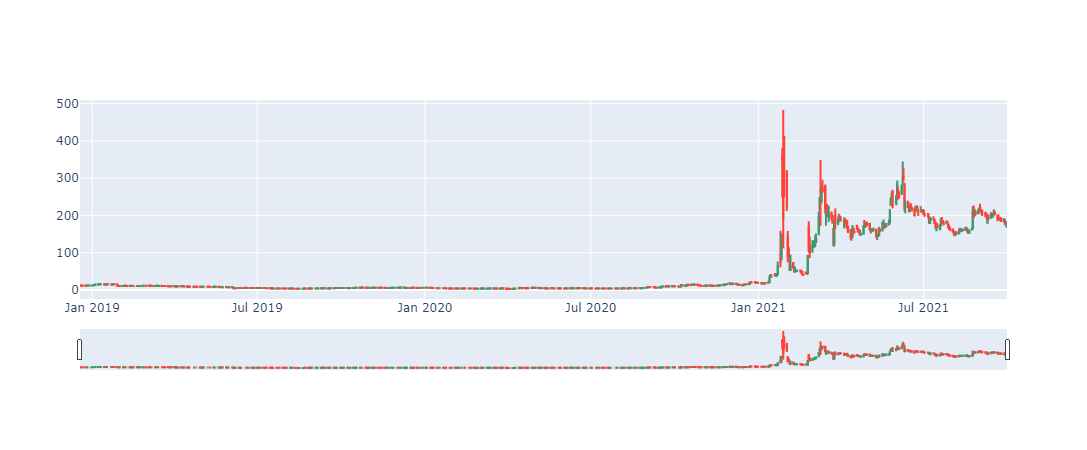

In [230]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock.index,
                open=df_stock['Open'],
                high=df_stock['High'],
                low=df_stock['Low'],
                close=df_stock['Close'])])
fig.update_traces(text=df_stock['pattern'], selector=dict(type='candlestick'))
fig.show()

In [231]:
pattern_dict = {
    'Bullish swing': 'upswing pattern',
    'Bearish swing': 'downward pattern',
    'Bullish pinbar': 'upswing hammer',
    'Bearish pinbar': 'downswing hammer',
    'Inside bar': 'trend change',
    'Outside bar': 'trend change',
    'Bullish engulfing': 'upswing from downtrend',
    'Bearish engulfing': 'downswing from uptrend',
    'No pattern': 'No pattern detected'
    }

In [232]:
today = df_stock['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is Outside bar, trend change


In [233]:
import datetime
today_date = datetime.date.today()
today_date = str(today_date)
today_date
#& df_stock['squeeze_on'] == df_stock['squeeze_threshold']
#df_stock["value"] > df_stock['value_threshold']

'2021-09-30'

In [234]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker(index):
    if (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index] > df_stock['m_avg_34'][index] > df_stock['m_avg_55'][index] > df_stock['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index] < df_stock['m_avg_34'][index] < df_stock['m_avg_55'][index] < df_stock['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [235]:
df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [236]:
momentum_checker(-1)

neutral


In [237]:
df_stock.shape

(701, 46)

In [238]:
ADX_trend_flag(-1)

neutral or sideways trend


In [239]:
def warning(index):
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.')
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_34'][index]):
        print('8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [240]:
warning(-1)

Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.
8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema


In [241]:
def squeeze_momentum(index):
    if (df_stock['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [242]:
squeeze_momentum(-1)

squeeze is on
stock is in a mark down mode


In [243]:
df = yf.download(value,'2021-03-04', '2021-09-30')

[*********************100%***********************]  1 of 1 completed


In [244]:
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [245]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [246]:
# Fibonacci Levels considering original trend as upward move
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff

In [247]:
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(price_max, level4, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

No handles with labels found to put in legend.


In [248]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock['value_threshold'] = abs(df_stock['value'].min()*.05)
df_stock['squeeze_threshold'] = 1.0
df_stock["squeeze_entry"] = np.logical_and(np.greater(df_stock["value"], df_stock['value_threshold']), 
                                           np.equal(df_stock['squeeze_on'], df_stock['squeeze_threshold']))
df_stock['squeeze_entry'] = df_stock['squeeze_entry'].astype(float)
df_stock['Entry/Exit'] = df_stock['squeeze_entry'].diff()
df_stock_clean = df_stock.dropna()


In [249]:
df_stock.shape

(701, 50)

In [250]:
len(colors)

716

In [251]:
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*1.15):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal


In [252]:
buy_price, sell_price, squeeze_signal = implement_bb_strategy(df_stock["Close"], df_stock['squeeze_on'], df_stock['value'], 
                                                              df_stock['upper_KC'], df_stock['value_threshold'], df_stock['colors'])

In [253]:
df_stock['buy_price'] =  buy_price
df_stock['sell_price'] = sell_price
df_stock['squeeze_signal'] = squeeze_signal

In [254]:
df_stock['squeeze_on'][20]

0.0

In [255]:
# #from math import isclose

# #def discretionary(row):
#     #for row in df_stock.values:
#         i#f row[32] == 1:
#             temp_close = row[3]
#             val = 1
#         elif row[32] == 0:
#             try:
#                 if np.logical_and(np.greater((row[19]-temp_close), row[35]), row[32]):
#                     val = -1
#                 else:
#                     val = 0
#             except:
#                 val = 0
#     return val

# df_stock['discretionary_exit'] = df_stock.apply(discretionary, axis = 1)

In [256]:
df_stock

Open        High         Low       Close   Volume  \
Date                                                                  
2018-12-19   12.341278   12.554058   12.109154   12.167185  2425900   
2018-12-20   12.186529   12.515371   11.809326   12.022107  2671200   
2018-12-21   11.983419   12.263903   11.383765   11.567530  4423000   
2018-12-24   11.577202   11.625561   11.258031   11.287046  1328500   
2018-12-26   11.335406   11.993091   11.180656   11.993091  2404200   
...                ...         ...         ...         ...      ...   
2021-09-24  191.000000  191.720001  184.110001  185.160004  1679900   
2021-09-27  185.919998  192.050003  185.869995  189.479996  1470100   
2021-09-28  188.000000  190.809998  178.000000  178.600006  1770500   
2021-09-29  180.089996  184.479996  174.610001  175.919998  1897700   
2021-09-30  175.000000  185.330002  166.789993  177.500000  2759990   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2018-12-19        0.0             0       12.723011   13.991819   11.454203   
2018-12-20        0.0             0       12.656035   13.839878   11.472192   
2018-12-21        0.0             0       12.552055   13.864484   11.239626   
2018-12-24        0.0             0       12.431248   13.902546   10.959951   
2018-12-26        0.0             0       12.389416   13.812635   10.966197   
...               ...           ...             ...         ...         ...   
2021-09-24        0.0             0      194.043134  212.026913  176.059356   
2021-09-27        0.0             0      193.608550  212.164333  175.052766   
2021-09-28        0.0             0      192.179165  212.514627  171.843702   
2021-09-29        0.0             0      190.630673  211.127165  170.134180   
2021-09-30        0.0             0      189.380132  209.974485  168.785779   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2018-12-19   12.427703   12.741532   12.927973   13.090793   13.208764   
2018-12-20   12.337571   12.675842   12.874335   13.047132   13.172252   
2018-12-21   12.166451   12.574685   12.797116   12.986993   13.123295   
2018-12-24   11.971027   12.457202   12.708060   12.918237   13.067734   
2018-12-26   11.975930   12.414871   12.665971   12.880995   13.035477   
...                ...         ...         ...         ...         ...   
2021-09-24  192.949357  193.865055  191.667465  189.678303  184.640820   
2021-09-27  192.178388  193.466414  191.542467  189.671220  184.748357   
2021-09-28  189.160969  192.114922  190.802898  189.275820  184.611727   
2021-09-29  186.218531  190.642656  189.952446  188.798826  184.418577   
2021-09-30  184.281080  189.447869  189.240878  188.395297  184.264831   

                  tr0       tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                            
2018-12-19   0.444904  0.241797   0.203107   0.444904   13.911430   11.534592   
2018-12-20   0.706044  0.348186   0.357859   0.706044   13.864877   11.447193   
2018-12-21   0.880138  0.241796   0.638342   0.880138   13.811227   11.292882   
2018-12-24   0.367530  0.058032   0.309499   0.367530   13.642601   11.219895   
2018-12-26   0.812434  0.706044   0.106390   0.812434   13.638485   11.140346   
...               ...       ...        ...        ...         ...         ...   
2021-09-24   7.610001  0.479996   7.130005   7.610001  220.290205  167.796064   
2021-09-27   6.180008  6.889999   0.709991   6.889999  218.722250  168.494849   
2021-09-28  12.809998  1.330002  11.479996  12.809998  217.338892  167.019437   
2021-09-29   9.869995  5.879990   3.990005   9.869995  215.297696  165.963649   
2021-09-30  18.540009  9.410004   9.130005  18.540009  215.175610  163.584655   

                  atr    plus_di   minus_di      

In [257]:
# Visualize exit position relative to close price
exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [69]:
position = []
for i in range(len(squeeze_signal)):
    if df_stock['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock['Close']
squeeze_signal = pd.DataFrame(squeeze_signal).rename(columns = {0:'squeeze_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock.index)

frames = [close_price, squeeze_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0    2011-12-19   99.672516             0.0                 0
1    2011-12-20  102.688599             0.0                 0
2    2011-12-21  102.887459             0.0                 0
3    2011-12-22  103.798935             0.0                 0
4    2011-12-23  104.726974             0.0                 0
...         ...         ...             ...               ...
2457 2021-09-24  443.910004             0.0                 0
2458 2021-09-27  442.640015             0.0                 0
2459 2021-09-28  433.720001             0.0                 0
2460 2021-09-29  434.450012             0.0                 0
2461 2021-09-30  430.700012             0.0                 0

[2462 rows x 4 columns]

In [70]:
stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)


Profit gained from the Squeeze strategy by investing $100k in spy is 263375.11
Profit percentage of the Squeeze strategy : 263%
263375.109085083


In [71]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go

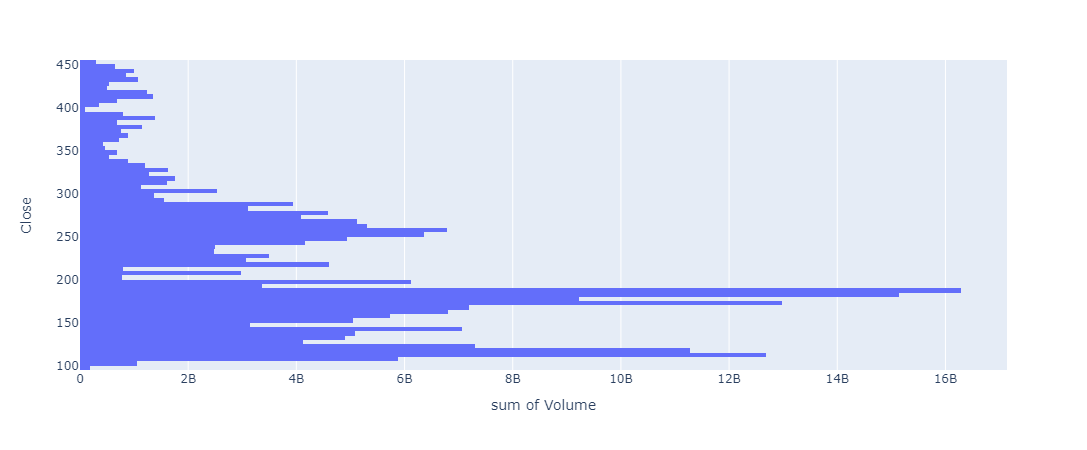

In [72]:
px.histogram(df_stock, x='Volume', y='Close', nbins=150, orientation='h').show()

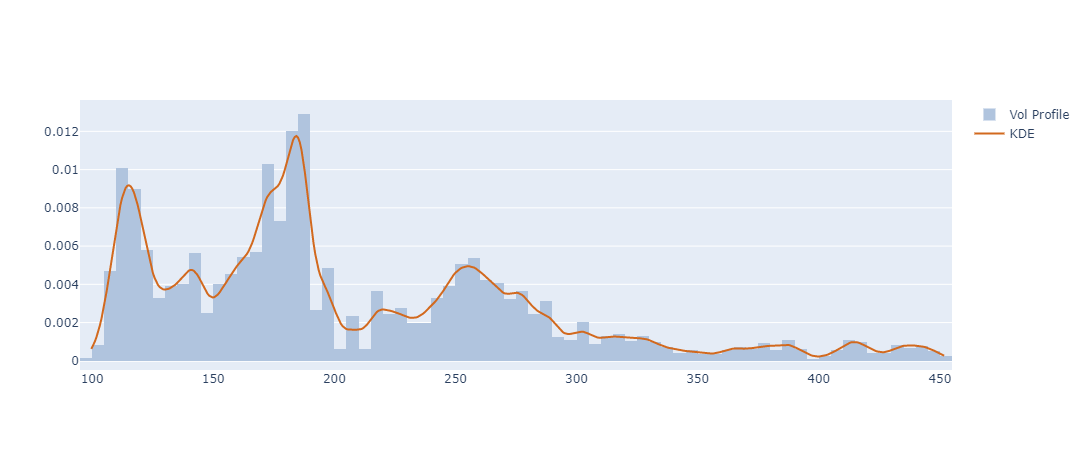

In [73]:
kde_factor = 0.05
num_samples = 500
close = df_stock['Close']
volume = df_stock['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

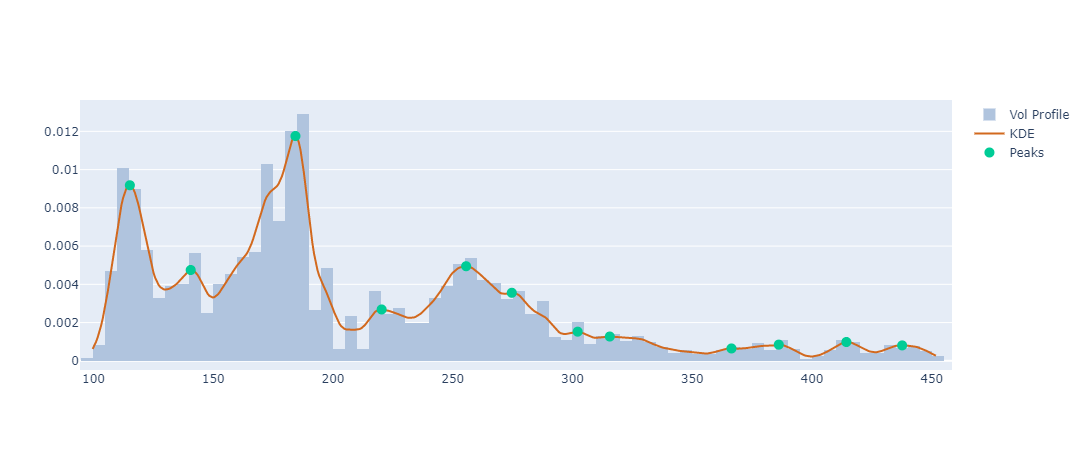

In [74]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [191]:
df_stock.to_csv('spy.csv')

In [75]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'squeeze_on', 'upper_KC', 'lower_KC', 'squeeze_signal']

# Filter by x-variable list
df_stock[x_var_list]

Open        High         Low       Close  Moving average  \
Date                                                                         
2011-12-19  101.139138  101.354577   99.457078   99.672516      101.370128   
2011-12-20  101.238546  102.862604   99.738779  102.688599      101.496117   
2011-12-21  102.688596  103.044895  101.710846  102.887459      101.629026   
2011-12-22  103.268630  103.906657  102.937195  103.798935      101.836249   
2011-12-23  104.130380  104.760119  103.914948  104.726974      102.112237   
...                ...         ...         ...         ...             ...   
2021-09-24  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-27  442.809998  444.049988  441.899994  442.640015      442.948924   
2021-09-28  439.690002  440.040009  432.940002  433.720001      442.069979   
2021-09-29  435.190002  437.040009  433.850006  434.450012      441.344268   
2021-09-30  436.019989  436.760010  430.090088  430.700012      440.330529   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2011-12-19  106.584497   96.155760  101.027723   -1.069156         0.0   
2011-12-20  106.648516   96.343717  101.396806    3.025992         0.0   
2011-12-21  106.647077   96.610974  101.728063    0.193654         0.0   
2011-12-22  106.289025   97.383473  102.188257    0.885896         0.0   
2011-12-23  105.792366   98.432108  102.752416    0.894074         0.0   
...                ...         ...         ...         ...         ...   
2021-09-24  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-27  453.819313  432.078535  441.710576   -0.286092         0.0   
2021-09-28  453.719786  430.420172  439.934893   -2.015185         0.0   
2021-09-29  453.436795  429.251741  438.716030    0.168314         0.0   
2021-09-30  453.239294  427.421765  436.934693   -0.863160         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2011-12-19  105.152045   97.588212             0.0  
2011-12-20  105.515276   97.476957             0.0  
2011-12-21  105.524871   97.733180             0.0  
2011-12-22  105.562623   98.109874             0.0  
2011-12-23  105.674070   98.550403             0.0  
...                ...         ...             ...  
2021-09-24  452.661399  433.301482             0.0  
2021-09-27  452.139794  433.758054             0.0  
2021-09-28  452.188954  431.951004             0.0  
2021-09-29  451.146974  431.541562             0.0  
2021-09-30  450.454793  430.206265             0.0  

[2462 rows x 13 columns]

In [76]:
# Shift DataFrame values by 1
df_stock[x_var_list] = df_stock[x_var_list].shift(1)
df_stock[x_var_list].tail()

Open        High         Low       Close  Moving average  \
Date                                                                         
2021-09-24  439.850006  444.890015  439.600006  443.179993      442.883697   
2021-09-27  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-28  442.809998  444.049988  441.899994  442.640015      442.948924   
2021-09-29  439.690002  440.040009  432.940002  433.720001      442.069979   
2021-09-30  435.190002  437.040009  433.850006  434.450012      441.344268   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2021-09-24  453.788387  431.979007  440.740741    1.215002         0.0   
2021-09-27  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-28  453.819313  432.078535  441.710576   -0.286092         0.0   
2021-09-29  453.719786  430.420172  439.934893   -2.015185         0.0   
2021-09-30  453.436795  429.251741  438.716030    0.168314         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2021-09-24  452.839647  432.927747             0.0  
2021-09-27  452.661399  433.301482             0.0  
2021-09-28  452.139794  433.758054             0.0  
2021-09-29  452.188954  431.951004             0.0  
2021-09-30  451.146974  431.541562             0.0

In [77]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)

# Display sample data
df_stock.head()

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-20  101.139138  101.354577   99.457078   99.672516  225418100   
2011-12-21  101.238546  102.862604   99.738779  102.688599  194230900   
2011-12-22  102.688596  103.044895  101.710846  102.887459  119465400   
2011-12-23  103.268630  103.906657  102.937195  103.798935   92187200   
2011-12-27  104.130380  104.760119  103.914948  104.726974   86075700   

            Dividends  Stock Splits  Moving average    upper_BB   lower_BB  \
Date                                                                         
2011-12-20        0.0             0      101.370128  106.584497  96.155760   
2011-12-21        0.0             0      101.496117  106.648516  96.343717   
2011-12-22        0.0             0      101.629026  106.647077  96.610974   
2011-12-23        0.0             0      101.836249  106.289025  97.383473   
2011-12-27        0.0             0      102.112237  105.792366  98.432108   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-20  101.027723  101.494310  101.427551  101.284499  101.121866   
2011-12-21  101.396806  101.621465  101.513817  101.349652  101.175731   
2011-12-22  101.728063  101.820135  101.648582  101.448716  101.255103   
2011-12-23  102.188257  102.085264  101.829798  101.580684  101.359316   
2011-12-27  102.752416  102.333693  102.004922  101.710086  101.462087   

                 tr0       tr1       tr2        tr    upper_KC   lower_KC  \
Date                                                                        
2011-12-20  3.123825  3.190088  0.066263  3.190088  105.152045  97.588212   
2011-12-21  1.334049  0.356296  0.977753  1.334049  105.515276  97.476957   
2011-12-22  0.969462  1.019198  0.049736  1.019198  105.524871  97.733180   
2011-12-23  0.845171  0.961184  0.116013  0.961184  105.562623  98.109874   
2011-12-27  0.629739  0.356288  0.273451  0.629739  105.674070  98.550403   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                
2011-12-20  2.011079  24.000411  22.797932  11.812889         0.0   
2011-12-21  1.920786  23.995024  22.139325  11.149603         0.0   
2011-12-22  1.800548  27.209550  21.907524  10.668019         0.0   
2011-12-23  1.688612  30.570680  21.669865  10.709484         0.0   
2011-12-27  1.547406  32.458538  21.938187  11.179203         0.0   

            squeeze_off     value  pct_change  profitable? colors     slow_K  \
Date                                                                           
2011-12-20          1.0  2.053073   -1.069156            1   cyan  37.045639   
2011-12-21          1.0  2.073135    3.025992            1   cyan  46.526612   
2011-12-22          1.0  2.149064    0.193654            1   cyan  68.865034   
2011-12-23          1.0  2.139684    0.885896            1   blue  81.621839   
2011-12-27          1.0  1.913862    0.894074            1   blue  91.866710   

               fast_K     rsi_14  Overbought  Oversold  Bullish swing  \
Date                                                                    
2011-12-20  60.671665  62.506864          70        30          False   
2011-12-21  64.405256  63.131217          70        30          False   
2011-12-22  81.518180  65.931569          70        30          False   
2011-12-23  98.942082  68.550775          70        30          False   
2011-12-27  95.139867  68.781518          70        30          False   

            Bearish swing  Bullish pinbar  Bearish pinbar  Inside bar  \
Date                                                                    
2011-12-20          False           False           False       False   
2011-12-21          False           False           False       False   
2011-12-22          False           False          

In [78]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2011-12-20  101.139138  101.354577   99.457078   99.672516  225418100   
2011-12-21  101.238546  102.862604   99.738779  102.688599  194230900   
2011-12-22  102.688596  103.044895  101.710846  102.887459  119465400   
2011-12-23  103.268630  103.906657  102.937195  103.798935   92187200   
2011-12-27  104.130380  104.760119  103.914948  104.726974   86075700   
...                ...         ...         ...         ...        ...   
2021-09-24  439.850006  444.890015  439.600006  443.179993   62025800   
2021-09-27  441.440002  444.670013  441.209991  443.910004   61371100   
2021-09-28  442.809998  444.049988  441.899994  442.640015  130436300   
2021-09-29  439.690002  440.040009  432.940002  433.720001   82142500   
2021-09-30  435.190002  437.040009  433.850006  434.450012   44544562   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2011-12-20        0.0             0      101.370128  106.584497   96.155760   
2011-12-21        0.0             0      101.496117  106.648516   96.343717   
2011-12-22        0.0             0      101.629026  106.647077   96.610974   
2011-12-23        0.0             0      101.836249  106.289025   97.383473   
2011-12-27        0.0             0      102.112237  105.792366   98.432108   
...               ...           ...             ...         ...         ...   
2021-09-24        0.0             0      442.883697  453.788387  431.979007   
2021-09-27        0.0             0      442.981441  453.905427  432.057455   
2021-09-28        0.0             0      442.948924  453.819313  432.078535   
2021-09-29        0.0             0      442.069979  453.719786  430.420172   
2021-09-30        0.0             0      441.344268  453.436795  429.251741   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2011-12-20  101.027723  101.494310  101.427551  101.284499  101.121866   
2011-12-21  101.396806  101.621465  101.513817  101.349652  101.175731   
2011-12-22  101.728063  101.820135  101.648582  101.448716  101.255103   
2011-12-23  102.188257  102.085264  101.829798  101.580684  101.359316   
2011-12-27  102.752416  102.333693  102.004922  101.710086  101.462087   
...                ...         ...         ...         ...         ...   
2021-09-24  440.740741  443.006303  442.338870  439.303013  432.672606   
2021-09-27  441.445022  442.973004  442.356079  439.422192  432.894104   
2021-09-28  441.710576  442.131822  441.862589  439.218542  432.912458   
2021-09-29  439.934893  441.433476  441.439013  439.048238  432.946625   
2021-09-30  438.716030  440.457706  440.825356  438.750087  432.896701   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2011-12-20  3.123825  3.190088  0.066263  3.190088  105.152045   97.588212   
2011-12-21  1.334049  0.356296  0.977753  1.334049  105.515276   97.476957   
2011-12-22  0.969462  1.019198  0.049736  1.019198  105.524871   97.733180   
2011-12-23  0.845171  0.961184  0.116013  0.961184  105.562623   98.109874   
2011-12-27  0.629739  0.356288  0.273451  0.629739  105.674070   98.550403   
...              ...       ...       ...       ...         ...         ...   
2021-09-24  3.460022  1.490021  1.970001  3.460022  452.839647  432.927747   
2021-09-27  2.149994  0.139984  2.010010  2.149994  452.661399  433.301482   
2021-09-28  7.100006  2.600006  9.700012  9.700012  452.139794  433.758054   
2021-09-29  3.190002  3.320007  0.130005  3.320007  452.188954  431.951004   
2021-09-30  6.669922  2.309998  4.359924  6.669922  451.146974  431.541562   

                 atr    plus_di   minus_di        adx  squeeze

In [79]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2019-09-14"

# Construct testing start and end dates
testing_start =  "2019-09-15"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2011-12-20
Training End: 2019-09-14
Testing Start: 2019-09-15
Testing End: 2021-09-30


In [80]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Open        High         Low       Close  Moving average  \
Date                                                                         
2019-09-09  287.124185  287.692325  286.401969  287.008606      281.418142   
2019-09-10  288.058286  288.154558  286.151626  287.153107      281.964329   
2019-09-11  286.344169  287.153077  285.005677  287.085663      282.452075   
2019-09-12  287.413048  289.213768  286.719719  289.127106      283.087792   
2019-09-13  290.090044  291.255211  289.281166  290.128571      283.758343   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2019-09-09  288.914006  273.922278  282.944134    0.077234         1.0   
2019-09-10  290.146385  273.782273  283.879461    0.050347         0.0   
2019-09-11  291.092126  273.812025  284.591950   -0.023487         0.0   
2019-09-12  292.528848  273.646736  285.599763    0.711092         0.0   
2019-09-13  293.336919  274.179766  286.606164    0.346375         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2019-09-09  288.924611  273.911672             0.0  
2019-09-10  289.152562  274.776096             0.0  
2019-09-11  289.377274  275.526876             0.0  
2019-09-12  289.836891  276.338694             0.0  
2019-09-13  290.280815  277.235870             0.0

Date
2019-09-09    1.0
2019-09-10    1.0
2019-09-11    0.0
2019-09-12    1.0
2019-09-13    1.0
Name: Positive Return, dtype: float64

In [81]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Open        High         Low       Close  Moving average  \
Date                                                                         
2021-09-24  439.850006  444.890015  439.600006  443.179993      442.883697   
2021-09-27  441.440002  444.670013  441.209991  443.910004      442.981441   
2021-09-28  442.809998  444.049988  441.899994  442.640015      442.948924   
2021-09-29  439.690002  440.040009  432.940002  433.720001      442.069979   
2021-09-30  435.190002  437.040009  433.850006  434.450012      441.344268   

              upper_BB    lower_BB    m_avg_08  pct_change  squeeze_on  \
Date                                                                     
2021-09-24  453.788387  431.979007  440.740741    1.215002         0.0   
2021-09-27  453.905427  432.057455  441.445022    0.164721         0.0   
2021-09-28  453.819313  432.078535  441.710576   -0.286092         0.0   
2021-09-29  453.719786  430.420172  439.934893   -2.015185         0.0   
2021-09-30  453.436795  429.251741  438.716030    0.168314         0.0   

              upper_KC    lower_KC  squeeze_signal  
Date                                                
2021-09-24  452.839647  432.927747             0.0  
2021-09-27  452.661399  433.301482             0.0  
2021-09-28  452.139794  433.758054             0.0  
2021-09-29  452.188954  431.951004             0.0  
2021-09-30  451.146974  431.541562             0.0

Date
2021-09-24    1.0
2021-09-27    1.0
2021-09-28    0.0
2021-09-29    0.0
2021-09-30    1.0
Name: Positive Return, dtype: float64

In [82]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [83]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results

Positive Return  Predicted Value
Date                                        
2019-09-16              0.0              0.0
2019-09-17              0.0              0.0
2019-09-18              1.0              1.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0
...                     ...              ...
2021-09-24              1.0              1.0
2021-09-27              1.0              1.0
2021-09-28              0.0              0.0
2021-09-29              0.0              0.0
2021-09-30              1.0              1.0

[516 rows x 2 columns]

In [84]:
# Save the pre-trained model
from joblib import dump, load
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [85]:
results.head()

Positive Return  Predicted Value
Date                                        
2019-09-16              0.0              0.0
2019-09-17              0.0              0.0
2019-09-18              1.0              1.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0

In [86]:
y_test.head()

Date
2019-09-16    0.0
2019-09-17    0.0
2019-09-18    1.0
2019-09-19    1.0
2019-09-20    0.0
Name: Positive Return, dtype: float64

In [87]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])

In [88]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Date                                        
2019-09-16              0.0              0.0
2019-09-17              0.0              0.0
2019-09-18              1.0              1.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0
2019-09-23              0.0              0.0
2019-09-24              0.0              0.0
2019-09-25              0.0              0.0
2019-09-26              1.0              1.0
2019-09-27              0.0              0.0

<AxesSubplot:xlabel='Date'>

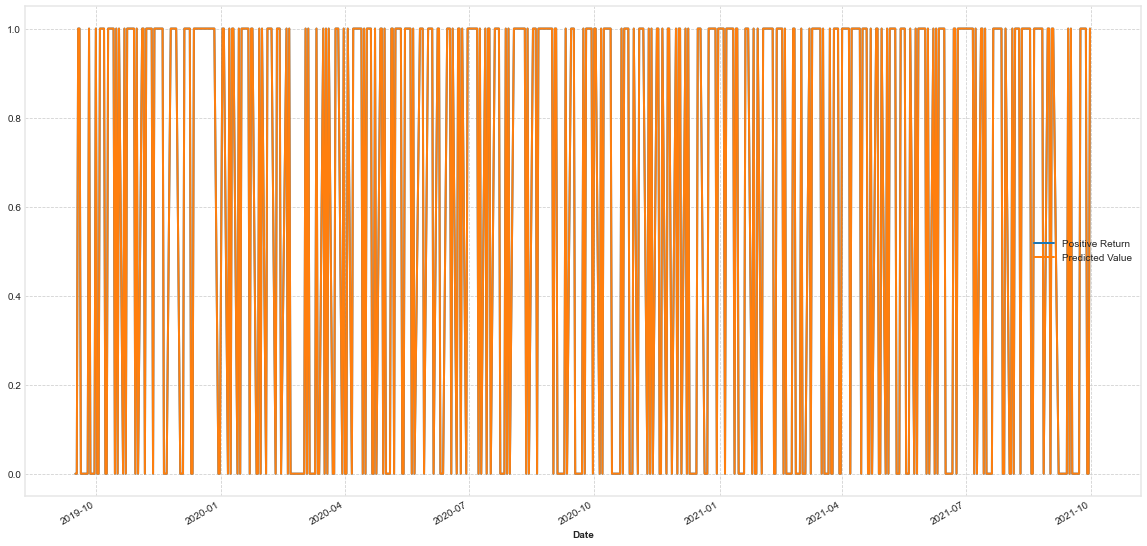

In [89]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

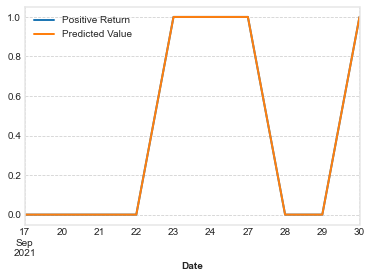

In [90]:
# Plot last 10 records of predicted vs. actual results
results[["Positive Return", "Predicted Value"]].tail(10).plot()

In [91]:
results['Return'] = df_stock['pct_change']
results

Positive Return  Predicted Value    Return
Date                                                  
2019-09-16              0.0              0.0 -0.066383
2019-09-17              0.0              0.0 -0.308885
2019-09-18              1.0              1.0  0.253229
2019-09-19              1.0              1.0  0.059809
2019-09-20              0.0              0.0 -0.006641
...                     ...              ...       ...
2021-09-24              1.0              1.0  1.215002
2021-09-27              1.0              1.0  0.164721
2021-09-28              0.0              0.0 -0.286092
2021-09-29              0.0              0.0 -2.015185
2021-09-30              1.0              1.0  0.168314

[516 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

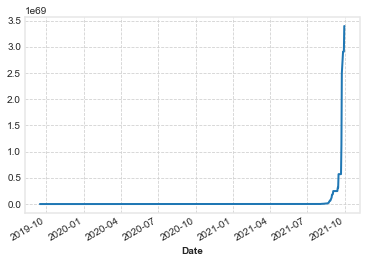

In [92]:
# Calculate cumulative return of the model
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Date'>

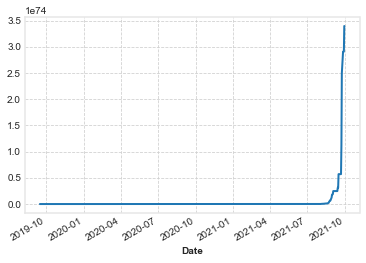

In [93]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [64]:
# Read your api key environment variable
from newsapi import NewsApiClient
load_dotenv()
api_key = os.getenv("NEWSAPI_KEY")

In [65]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [69]:
# Fetch the Bitcoin news articles
stock_headlines = newsapi.get_everything(q=value,
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('stock.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

In [70]:
# Fetch the Bitcoin news articles
stock_headlines = newsapi.get_everything(q='fed',
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('fed.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

In [71]:
help(newsapi.get_everything)

Help on method get_everything in module newsapi.newsapi_client:

get_everything(q=None, sources=None, domains=None, exclude_domains=None, from_param=None, to=None, language=None, sort_by=None, page=None, page_size=None) method of newsapi.newsapi_client.NewsApiClient instance
        Search through millions of articles from over 5,000 large and small news sources and blogs.
    
        Optional parameters:
            (str) q - return headlines w/ specified coin! Valid values are:
                        'bitcoin', 'trump', 'tesla', 'ethereum', etc
    
            (str) sources - return headlines of news sources! some Valid values are:
                        'bbc-news', 'the-verge', 'abc-news', 'crypto coins news',
                        'ary news','associated press','wired','aftenposten','australian financial review','axios',
                        'bbc news','bild','blasting news','bloomberg','business insider','engadget','google news',
                        'hacker news','info

In [72]:
# Create the Bitcoin sentiment scores DataFrame
tc = pd.read_json ('stock.json')
#parse the json and load into a dataframe
stock_df = json_normalize(stock_headlines['articles'])
#drop all columns except for description
stock_df = stock_df.drop(['author', 'title', 'url','urlToImage','publishedAt','content','source.id','source.name'], axis=1)
#instantiate vader sentiment 
sentiment_title = stock_df.apply(lambda x : analyzer.polarity_scores(x['description']), axis=1)
#add a column for each sentimement metric
stock_df['Comp'] =sentiment_title.apply(lambda x : x.get('compound') )
stock_df['Pos'] =sentiment_title.apply(lambda x : x.get('pos') )
stock_df['Neu'] =sentiment_title.apply(lambda x : x.get('neu') )
stock_df['Neg'] =sentiment_title.apply(lambda x : x.get('neg') )
stock_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [75]:
# Create the Bitcoin sentiment scores DataFrame
tc = pd.read_json ('fed.json')
#parse the json and load into a dataframe
fed_df = json_normalize(stock_headlines['articles'])
#drop all columns except for description
fed_df = fed_df.drop(['author', 'title', 'url','urlToImage','publishedAt','content','source.id','source.name'], axis=1)
#instantiate vader sentiment 
sentiment_title = fed_df.apply(lambda x : analyzer.polarity_scores(x['description']), axis=1)
#add a column for each sentimement metric
fed_df['Comp'] =sentiment_title.apply(lambda x : x.get('compound') )
fed_df['Pos'] =sentiment_title.apply(lambda x : x.get('pos') )
fed_df['Neu'] =sentiment_title.apply(lambda x : x.get('neu') )
fed_df['Neg'] =sentiment_title.apply(lambda x : x.get('neg') )
fed_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [74]:
# Describe the Bitcoin Sentiment
stock_df.describe()

Comp         Pos         Neu         Neg
count  100.000000  100.000000  100.000000  100.000000
mean     0.113949    0.093960    0.838230    0.067780
std      0.450142    0.088097    0.114135    0.080951
min     -0.888500    0.000000    0.530000    0.000000
25%     -0.115300    0.000000    0.773750    0.000000
50%      0.025800    0.089000    0.849500    0.051000
75%      0.476700    0.143000    0.920000    0.120250
max      0.900100    0.470000    1.000000    0.304000

In [76]:
# Describe the Bitcoin Sentiment
fed_df.describe()

Comp         Pos         Neu         Neg
count  100.000000  100.000000  100.000000  100.000000
mean     0.113949    0.093960    0.838230    0.067780
std      0.450142    0.088097    0.114135    0.080951
min     -0.888500    0.000000    0.530000    0.000000
25%     -0.115300    0.000000    0.773750    0.000000
50%      0.025800    0.089000    0.849500    0.051000
75%      0.476700    0.143000    0.920000    0.120250
max      0.900100    0.470000    1.000000    0.304000

In [77]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from string import punctuation
import re

In [78]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [79]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a list of the words
    tokens = word_tokenize(re_clean)
    # Convert the words to lowercase
    tokens = [t.lower() for t in tokens]
    # Remove the punctuation
    words = [t.translate(str.maketrans('','',string.punctuation)) for t in tokens]
    # Remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # Lemmatize Words into root words
    tokens = ', '.join([lemmatizer.lemmatize(word) for word in words])
    return tokens

In [80]:
# Create a new tokens column for Bitcoin
stock_df['tokens'] = stock_df.apply(lambda x : tokenizer(x['description']), axis=1)
stock_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [81]:
# Create a new tokens column for Bitcoin
fed_df['tokens'] = fed_df.apply(lambda x : tokenizer(x['description']), axis=1)
fed_df

description    Comp    Pos    Neu  \
0   From backpacks to boxer briefs, we have the co...  0.5859  0.179  0.821   
1   The chainless Schaeffler Free Drive system wor...  0.8225  0.211  0.789   
2   The Fed is expected to signal that it will slo...  0.4019  0.097  0.903   
3   Workers in China are fed up with the brutal 12... -0.1027  0.149  0.685   
4   Here’s what you need to know at the end of the...  0.0000  0.000  1.000   
5   One obstacle to Federal Reserve Chair Jerome P... -0.0516  0.064  0.866   
6   U.S. Federal Reserve Chair Jerome Powell and o...  0.0000  0.000  1.000   
7   U.S. consumer and public interest groups on Mo... -0.4939  0.066  0.752   
8   omThe U.S. Federal Reserve is likely to announ...  0.3612  0.077  0.923   
9   * Fed expressing growth concern could be gold ...  0.7351  0.470  0.530   
10     Rebound Fails as Investors Await Fed Statement -0.3400  0.152  0.543   
11  S.Korean stocks end little changed on prospect... -0.0935  0.136  0.702   
12  * Dovish Fed continues to support risky assets...  0.3818  0.310  0.563   
13  US STOCKS-Wall St set to rise on easing Evergr...  0.2500  0.133  0.867   
14  S.Korean stocks end flat, U.S. CPI data in foc...  0.0000  0.000  1.000   
15  PRECIOUS-Gold firms on Evergrande risks; pre-F...  0.0772  0.192  0.640   
16  PRECIOUS-Gold starts week on back foot as Fed ...  0.2023  0.160  0.733   
17  * Gold seen weaker long-term as Fed normalizes... -0.4404  0.000  0.828   
18  PRECIOUS-Gold prices ease as dollar firms on F...  0.3612  0.185  0.815   
19  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
20  "Doing things like this, although not prohibit... -0.6115  0.074  0.735   
21  * Fed says will likely begin tapering by as so...  0.0000  0.000  1.000   
22  * Gold skewed to downside long-term as Fed nor... -0.2500  0.000  0.882   
23  Stocks Plunge Amid China, Fed and Washington C...  0.0000  0.000  1.000   
24  After strong gains in early summer, hiring may...  0.3182  0.189  0.698   
25  The Federal Reserve will release research "soo...  0.3818  0.094  0.906   
26  Sell-off is unfolding and even a "lovey-dovey"... -0.3875  0.000  0.774   
27  Dow and S&P End Four-Day Skid after Fed Statement  0.0000  0.000  1.000   
28  Gold steadied near a four-week high on Monday,...  0.5106  0.161  0.776   
29  Hong Kong shares rose on Monday after U.S. Fed...  0.0516  0.084  0.840   
30  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
31  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
32  With little fanfare, all of the Federal Reserv...  0.0000  0.000  1.000   
33  World markets rallied on Thursday after the U....  0.3182  0.128  0.773   
34  U.S. stocks added to gains on Wednesday after ...  0.8074  0.256  0.744   
35  World markets rallied on Thursday after the U....  0.4767  0.140  0.764   
36  * KOSPI falls, foreigners net buyers * Korean ...  0.5574  0.133  0.814   
37  The Federal Reserve may not be able to shield ... -0.8885  0.000  0.752   
38  A look under the hood into what is driving the...  0.4588  0.088  0.912   
39  The Australian and New Zealand dollars were sl... -0.6494  0.000  0.858   
40  The S&P 500 and Nasdaq moved to fresh record h...  0.6908  0.130  0.870   
41  * Silver firms near one-month peak (Recasts, a...  0.0000  0.000  1.000   
42  The dollar rallied to a month-high in Asia on ... -0.7717  0.000  0.796   
43  * Fed's policy statement due at 1800 GMT (Reca...  0.0000  0.000  1.000   
44  Stocks found relief on Wednesday after teeteri...  0.4215  0.123  0.773   
45  U.S. stocks rose sharply higher Wednesday as i...  0.0000  0.000  1.000   
46  World stock markets rallied on Thursday and th... -0.6486  0.058  0.764   
47  World stock markets rallied on Thursday and th... -0.7003  0.000  0.851   
48  Euro zone bond yields sought direction on Mond... -0.3612  0.057  0.811   
49  Asian shares eased and the dollar held firm on...  0.4767  0.156  0.790   
50  The dolla

In [82]:
from collections import Counter
from nltk import ngrams
import nltk, re, string, collections
from collections import Counter
from nltk import ngrams
from nltk.collocations import *
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
#import janitor as jn
#import ConfigParser

In [83]:
# Generate the Bitcoin N-grams where N=2
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
#determine counts in the token column
sparse_matrix = word_vectorizer.fit_transform(stock_df['tokens'])
#sum counts
frequencies = sum(sparse_matrix).toarray()[0]
#create dataframe with ngram and count
stock_df_freq_2 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
stock_df_freq_2 = stock_df_freq_2.sort_values(by='frequency', ascending=False)
stock_df_freq_2.head(10)

frequency
federal reserve          48
central bank             25
jerome powell            16
chair jerome             12
interest rate             9
bank president            7
update price              7
china evergrande          7
reserve chair             7
add comment               7

In [84]:
# Generate the Bitcoin N-grams where N=2
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
#determine counts in the token column
sparse_matrix = word_vectorizer.fit_transform(fed_df['tokens'])
#sum counts
frequencies = sum(sparse_matrix).toarray()[0]
#create dataframe with ngram and count
fed_df_freq_2 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
fed_df_freq_2 = fed_df_freq_2.sort_values(by='frequency', ascending=False)
fed_df_freq_2.head(10)

frequency
federal reserve          48
central bank             25
jerome powell            16
chair jerome             12
interest rate             9
bank president            7
update price              7
china evergrande          7
reserve chair             7
add comment               7

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [86]:
#join all text in tokens column into 1 string
corpus_stock = stock_df['tokens'].str.cat(sep=', ')

In [87]:
#join all text in tokens column into 1 string
corpus_fed = fed_df['tokens'].str.cat(sep=', ')

In [88]:
# Generate the Bitcoin word cloud
#create word cloud
wc = WordCloud(background_color="white", max_words=200)
wc.generate(corpus_stock)
f = plt.figure(figsize=(150,150))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title(f"{value} WORD CLOUD",fontsize=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [89]:
# Generate the Bitcoin word cloud
#create word cloud
wc = WordCloud(background_color="white", max_words=200)
wc.generate(corpus_fed)
f = plt.figure(figsize=(150,150))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title(f"fed WORD CLOUD",fontsize=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Weekly Analysis

In [94]:
stock_df_wk = stock.history(period="20y", interval='1wk')
stock_df.index.duplicated().sum()
df_stock_wk = stock_df_wk.loc[~stock_df_wk.index.duplicated(keep='first')]
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2001-10-01   70.819975   74.275771   70.090645   73.089760  134806500.0   
2001-10-08   72.435370   75.182289   71.924158   74.636993  103300800.0   
2001-10-15   74.044023   75.761700   72.258191   73.171555   99714900.0   
2001-10-22   73.137458   76.197915   72.755750   75.195938  101759500.0   
2001-10-29   75.086895   75.352725   71.951454   74.466621  120413000.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  
Date                                 
2001-10-01        0.0             0  
2001-10-08        0.0             0  
2001-10-15        0.0             0  
2001-10-22        0.0             0  
2001-10-29        0.0             0  
...               ...           ...  
2021-09-06        0.0             0  
2021-09-13        0.0             0  
2021-09-20        0.0             0  
2021-09-27        0.0             0  
2021-09-30        0.0             0  

[1045 rows x 7 columns]

In [95]:
# calculate Bollinger Bands on weekly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_wk = df_stock_wk['Close'].ewm(span=length).mean()
df_stock_wk['Moving average weekly'] = m_avg_wk
# standard deviation
m_std_wk = df_stock_wk['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock_wk['upper_BB'] = m_avg_wk + mult * m_std_wk
# lower Bollinger Bands 
df_stock_wk['lower_BB'] = m_avg_wk - mult * m_std_wk

In [96]:
#Stacked Moving averages weekly
m_avg_08_wk = df_stock_wk['Close'].ewm(span=8).mean()
m_avg_21_wk = df_stock_wk['Close'].ewm(span=21).mean()
m_avg_34_wk = df_stock_wk['Close'].ewm(span=34).mean()
m_avg_55_wk = df_stock_wk['Close'].ewm(span=55).mean()
m_avg_89_wk = df_stock_wk['Close'].ewm(span=89).mean()

df_stock_wk['m_avg_08'] = m_avg_08_wk
df_stock_wk['m_avg_21'] = m_avg_21_wk
df_stock_wk['m_avg_34'] = m_avg_34_wk
df_stock_wk['m_avg_55'] = m_avg_55_wk
df_stock_wk['m_avg_89'] = m_avg_89_wk

In [97]:
# calculate Keltner Channel weekly
# first we need to calculate True Range
df_stock_wk['tr0'] = abs(df_stock_wk["High"] - df_stock_wk["Low"])
df_stock_wk['tr1'] = abs(df_stock_wk["High"] - df_stock_wk["Close"].shift())
df_stock_wk['tr2'] = abs(df_stock_wk["Low"] - df_stock_wk["Close"].shift())
df_stock_wk['tr'] = df_stock_wk[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_wk = df_stock_wk['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_wk['upper_KC'] = m_avg_wk + range_ma_wk * mult_KC
# lower Keltner Channel
df_stock_wk['lower_KC'] = m_avg_wk - range_ma_wk * mult_KC

In [98]:
#ADX Calculations weekly

plus_dm_wk = df_stock_wk["High"].diff()
minus_dm_wk = df_stock_wk["Low"].diff()
plus_dm_wk[plus_dm_wk < 0] = 0
minus_dm_wk[minus_dm_wk > 0] = 0

df_stock_wk['atr'] = df_stock_wk['tr'].ewm(span=14).mean()
df_stock_wk['plus_di'] = 100 * (plus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr'])
df_stock_wk['minus_di'] = abs(100 * (minus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr']))
dx_wk = (abs(df_stock_wk['plus_di'] - df_stock_wk['minus_di']) / abs(df_stock_wk['plus_di'] + df_stock_wk['minus_di'])) * 100
adx_wk = ((dx_wk.shift(1) * (14 - 1)) + dx_wk) / 14
df_stock_wk['adx'] = adx_wk.ewm(alpha = 1/14).mean()

In [99]:
# check for 'squeeze' weekly
df_stock_wk['squeeze_on'] = (df_stock_wk['lower_BB'] > df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] < df_stock_wk['upper_KC'])
df_stock_wk['squeeze_off'] = (df_stock_wk['lower_BB'] < df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] > df_stock_wk['upper_KC'])

In [100]:
# Momentum weekly
highest_wk = df_stock_wk['High'].rolling(window = length_KC).max()
lowest_wk = df_stock_wk['Low'].rolling(window = length_KC).min()
m1_wk = (highest_wk + lowest_wk) / 2
df_stock_wk['value'] = (df_stock_wk['Close'] - (m1_wk + m_avg_wk)/2)
fit_y_wk = np.array(range(0,length_KC))
df_stock_wk['value'] = df_stock_wk['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_wk, x, 1)[1], raw=True)

df_stock_wk[['squeeze_on', 'squeeze_off']] = (df_stock_wk[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock_wk["pct_change"] = df_stock_wk['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_wk =  [
    (df_stock_wk['pct_change'] > 0),
    (df_stock_wk['pct_change'] < 0)
]

label = [1, 0]
df_stock_wk['profitable?'] = np.select(conditions_wk, label) 
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-07-08   68.130002   68.625589   62.169141   63.222271  196756600.0   
2002-07-15   63.077748   64.220363   58.025473   58.307682  289709500.0   
2002-07-22   57.887799   59.147428   53.468779   58.920280  388024300.0   
2002-07-29   60.228091   63.015793   58.934049   59.739384  264039800.0   
2002-08-05   59.532894   63.284248   57.509234   62.836838  245429700.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-07-08        0.0             0              72.166122   81.236351   
2002-07-15        0.0             0              70.826249   81.974525   
2002-07-22        0.0             0              69.676807   81.893437   
2002-07-29        0.0             0              68.718665   81.460946   
2002-08-05        0.0             0              68.152222   80.798934   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548192  454.982271   
2021-09-13        0.0             0             430.542689  455.297338   
2021-09-20        0.0             0             431.815767  456.520469   
2021-09-27        0.0             0             432.066647  455.250076   
2021-09-30        0.0             0             432.013634  453.085419   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-07-08   63.095893   68.858665   72.319277   73.561694   74.336971   
2002-07-15   59.677972   66.513941   71.021804   72.609609   73.605757   
2002-07-22   57.460176   64.826427   69.903094   71.759665   72.942413   
2002-07-29   55.976384   63.695955   68.964963   71.017022   72.351618   
2002-08-05   55.505510   63.505038   68.400112   70.513964   71.929672   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114112  442.495577  428.426620  414.074230  393.689217   
2021-09-13  405.788041  441.938875  429.477874  415.555155  395.342831   
2021-09-20  407.111064  442.376904  430.789886  417.175432  397.077373   
2021-09-27  408.883218  440.615372  431.122625  418.162551  398.412110   
2021-09-30  410.941850  438.591958  431.157842  418.925263  399.594178   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-07-08   74.786568   6.456448  0.268442   6.188006   6.456448   79.139236   
2002-07-15   74.187106   6.194890  0.998092   5.196798   6.194890   78.300946   
2002-07-22   73.639488   5.678649  0.839746   4.838903   5.678649   77.510426   
2002-07-29   73.147607   4.081744  4.095513   0.013769   4.095513   76.585274   
2002-08-05   72.787482   5.775014  3.544864   2.230150   5.775014   76.358345   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488686   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077613   7.874796  3.468905   4.405891   7.874796  447.745234   
2021-09-20  371.718333  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112370  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-30  374.410096   6.760010  2.309998   4.450012   6.760010  450.412334   

              lower_KC       atr    plus_di   minus_di        

In [101]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_wk = df_stock_wk['value'][-1] > 0

enter_long_wk = long_cond1_wk and long_cond2_wk
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_wk = df_stock_wk['value'][-1] < 0
enter_short_wk = short_cond1_wk and short_cond2_wk

In [102]:
ohcl_wk = df_stock_wk[['Open', 'High', 'Close', 'Low']]
ohcl_wk.head()

Open       High      Close        Low
Date                                                  
2002-07-08  68.130002  68.625589  63.222271  62.169141
2002-07-15  63.077748  64.220363  58.307682  58.025473
2002-07-22  57.887799  59.147428  58.920280  53.468779
2002-07-29  60.228091  63.015793  59.739384  58.934049
2002-08-05  59.532894  63.284248  62.836838  57.509234

In [103]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_wk['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_wk['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_wk['value'][ind-1]:
      color='red'
  colors.append(color)

In [104]:
df_stock_wk['colors'] = colors

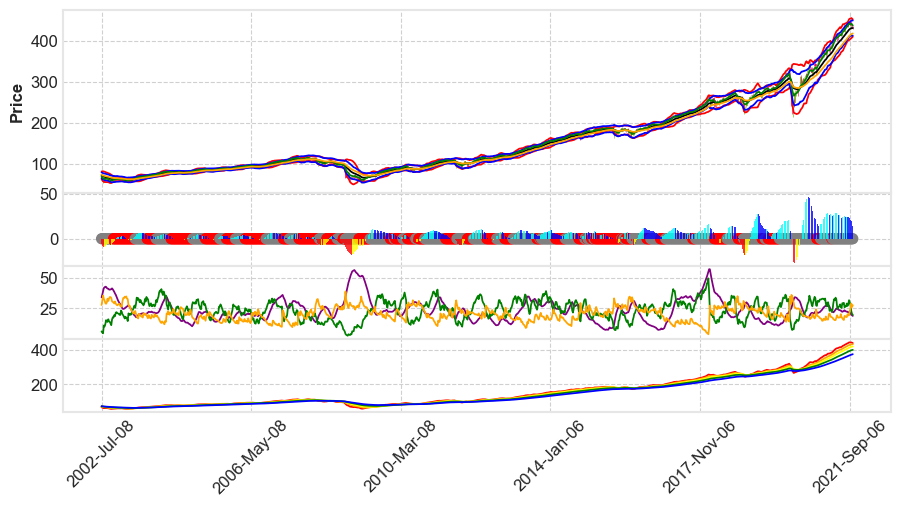

In [105]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
        mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
        mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
        mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

In [106]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_wk = stochastics( df_stock_wk, 'Low', 'High', 'Close', 14, 3 )
slow_k_wk = stochs_wk['k_slow'].values
fast_k_wk = stochs_wk['k_fast'].values
df_stock_wk["slow_K"] = slow_k_wk
df_stock_wk['fast_K'] = fast_k_wk
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-07-08   68.130002   68.625589   62.169141   63.222271  196756600.0   
2002-07-15   63.077748   64.220363   58.025473   58.307682  289709500.0   
2002-07-22   57.887799   59.147428   53.468779   58.920280  388024300.0   
2002-07-29   60.228091   63.015793   58.934049   59.739384  264039800.0   
2002-08-05   59.532894   63.284248   57.509234   62.836838  245429700.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-07-08        0.0             0              72.166122   81.236351   
2002-07-15        0.0             0              70.826249   81.974525   
2002-07-22        0.0             0              69.676807   81.893437   
2002-07-29        0.0             0              68.718665   81.460946   
2002-08-05        0.0             0              68.152222   80.798934   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548192  454.982271   
2021-09-13        0.0             0             430.542689  455.297338   
2021-09-20        0.0             0             431.815767  456.520469   
2021-09-27        0.0             0             432.066647  455.250076   
2021-09-30        0.0             0             432.013634  453.085419   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-07-08   63.095893   68.858665   72.319277   73.561694   74.336971   
2002-07-15   59.677972   66.513941   71.021804   72.609609   73.605757   
2002-07-22   57.460176   64.826427   69.903094   71.759665   72.942413   
2002-07-29   55.976384   63.695955   68.964963   71.017022   72.351618   
2002-08-05   55.505510   63.505038   68.400112   70.513964   71.929672   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114112  442.495577  428.426620  414.074230  393.689217   
2021-09-13  405.788041  441.938875  429.477874  415.555155  395.342831   
2021-09-20  407.111064  442.376904  430.789886  417.175432  397.077373   
2021-09-27  408.883218  440.615372  431.122625  418.162551  398.412110   
2021-09-30  410.941850  438.591958  431.157842  418.925263  399.594178   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-07-08   74.786568   6.456448  0.268442   6.188006   6.456448   79.139236   
2002-07-15   74.187106   6.194890  0.998092   5.196798   6.194890   78.300946   
2002-07-22   73.639488   5.678649  0.839746   4.838903   5.678649   77.510426   
2002-07-29   73.147607   4.081744  4.095513   0.013769   4.095513   76.585274   
2002-08-05   72.787482   5.775014  3.544864   2.230150   5.775014   76.358345   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488686   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077613   7.874796  3.468905   4.405891   7.874796  447.745234   
2021-09-20  371.718333  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112370  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-30  374.410096   6.760010  2.309998   4.450012   6.760010  450.412334   

              lower_KC       atr    plus_di   minus_di        

In [107]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_wk['rsi_14'] = get_rsi(df_stock_wk['Close'], 14)
df_stock_wk = df_stock_wk.dropna()
df_stock_wk['Overbought'] = 70
df_stock_wk['Oversold'] = 30
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-21   60.926735   62.848844   60.546460   62.364857  240391200.0   
2002-10-28   63.021722   63.118518   60.152383   62.413280  234112400.0   
2002-11-04   63.471129   64.349213   61.894718   61.984604  240841900.0   
2002-11-11   61.887822   63.298292   60.463520   63.194580  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-21        0.0             0              62.966996   70.810398   
2002-10-28        0.0             0              62.914085   70.022463   
2002-11-04        0.0             0              62.825295   69.352905   
2002-11-11        0.0             0              62.860562   68.732725   
2002-11-18        0.0             0              63.025793   68.193280   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548192  454.982271   
2021-09-13        0.0             0             430.542689  455.297338   
2021-09-20        0.0             0             431.815767  456.520469   
2021-09-27        0.0             0             432.066647  455.250076   
2021-09-30        0.0             0             432.013634  453.085419   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-21   55.123594   60.390762   63.196569   65.587737   67.654152   
2002-10-28   55.805707   60.840211   63.125048   65.399771   67.440040   
2002-11-04   56.297686   61.094521   63.020958   65.197969   67.218302   
2002-11-11   56.988398   61.561201   63.036799   65.079819   67.055559   
2002-11-18   57.858305   62.234536   63.178574   65.051056   66.956355   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114112  442.495577  428.426620  414.074230  393.689217   
2021-09-13  405.788041  441.938875  429.477874  415.555155  395.342831   
2021-09-20  407.111064  442.376904  430.789886  417.175432  397.077373   
2021-09-27  408.883218  440.615372  431.122625  418.162551  398.412110   
2021-09-30  410.941850  438.591958  431.157842  418.925263  399.594178   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-21   69.094999   2.302385  1.562559   0.739826   2.302385   70.722774   
2002-10-28   68.889409   2.966135  0.753662   2.212474   2.966135   70.503362   
2002-11-04   68.678756   2.454496  1.935933   0.518563   2.454496   70.169938   
2002-11-11   68.512818   2.834772  1.313688   1.521084   2.834772   70.052370   
2002-11-18   68.395106   3.118240  1.984324   1.133916   3.118240   70.130467   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488686   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077613   7.874796  3.468905   4.405891   7.874796  447.745234   
2021-09-20  371.718333  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112370  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-30  374.410096   6.760010  2.309998   4.450012   6.760010  450.412334   

              lower_KC       atr    plus_di   minus_di        

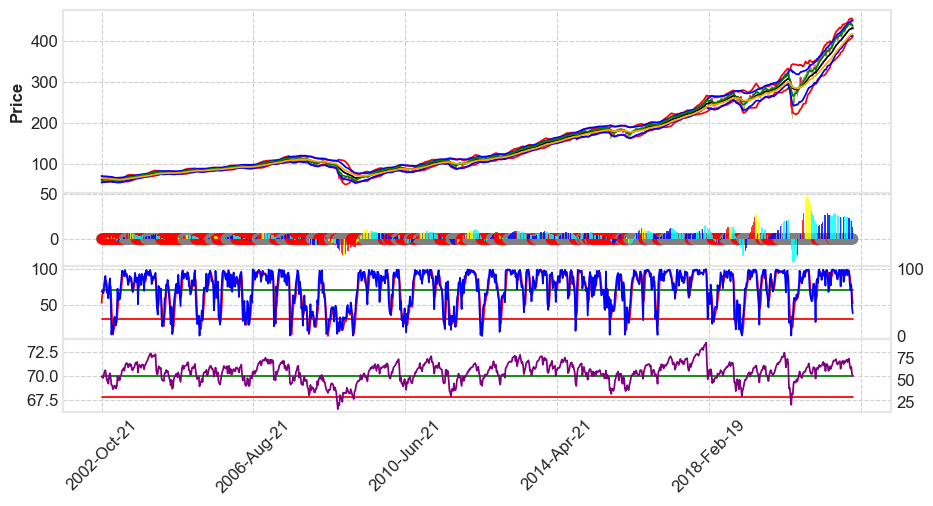

In [108]:
apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
         mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

In [82]:
for i in range(2,df_stock_wk.shape[0]):
    current = df_stock_wk.iloc[i,:]
    prev = df_stock_wk.iloc[i-1,:]
    prev_2 = df_stock_wk.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock_wk.index[i]  
# Bullish swing
    df_stock_wk.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock_wk.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock_wk.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock_wk.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock_wk.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock_wk.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock_wk.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock_wk.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock_wk.fillna(False, inplace=True)

In [83]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']


def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

In [84]:
#df_stock_dow.apply(convert, axis=1)
df_stock_wk['pattern'] = df_stock_wk.apply(convert, axis = 1)

In [88]:
df_stock_wk['pattern'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[No pattern]                                  371
[Bullish swing]                               152
[Bearish swing]                               126
[Outside bar]                                  81
[Bearish pinbar]                               52
[Bearish swing, Bullish pinbar]                36
[Bearish swing, Inside bar]                    31
[Bullish pinbar]                               28
[Bullish swing, Inside bar]                    27
[Bullish swing, Bearish swing, Inside bar]     18
[Bullish swing, Bearish pinbar]                17
[Bullish pinbar, Outside bar]                  16
[Outside bar, Bearish engulfing]               13
[Outside bar, Bullish engulfing]               10
[Bearish pinbar, Outside bar]                   7
[Inside bar]                                    5
Name: pattern, dtype: int64

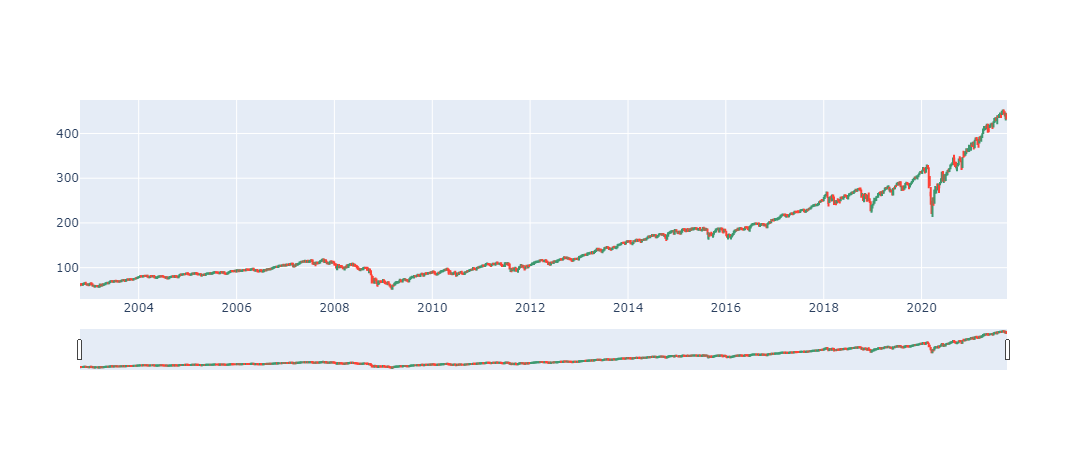

In [89]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock_wk.index,
                open=df_stock_wk['Open'],
                high=df_stock_wk['High'],
                low=df_stock_wk['Low'],
                close=df_stock_wk['Close'])])
fig.update_traces(text=df_stock_wk['pattern'], selector=dict(type='candlestick'))
fig.show()

In [90]:
today = df_stock_wk['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is Inside bar, trend change


In [109]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_wk(index):
    if (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index] > df_stock_wk['m_avg_34'][index] > df_stock_wk['m_avg_55'][index] > df_stock_wk['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index] < df_stock_wk['m_avg_34'][index] < df_stock_wk['m_avg_55'][index] < df_stock_wk['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [110]:
df_stock_wk['ADX_trend'] = 20

def ADX_trend_flag_wk(index):
    if (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] > df_stock_wk['minus_di'][index]):
        print('positive trend')
    elif (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] < df_stock_wk['minus_di'][index]):
        print('negative trend')
    elif (df_stock_wk['adx'][index] < df_stock_wk['ADX_trend'][index]):
        print('neutral or sideways trend')

In [111]:
def warning_wk(index):
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this weekly chart')
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_34'][index]):
        print('As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [112]:
def squeeze_momentum_wk(index):
    if (df_stock_wk['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock_wk['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock_wk['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock_wk['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock_wk['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [113]:
momentum_checker_wk(-1)

Positive momentum


In [114]:
ADX_trend_flag_wk(-1)

neutral or sideways trend


In [115]:
warning_wk(-1)

Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger


In [116]:
squeeze_momentum_wk(-1)

squeeze is off
stock is in a distribution mode


In [117]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock_wk['value_threshold'] = abs(df_stock_wk['value'].min()*.10)
df_stock_wk['squeeze_threshold'] = 1.0
df_stock_wk["squeeze_entry"] = np.logical_and(np.greater(df_stock_wk["value"], df_stock_wk['value_threshold']), 
                                           np.equal(df_stock_wk['squeeze_on'], df_stock_wk['squeeze_threshold']))
df_stock_wk['squeeze_entry'] = df_stock_wk['squeeze_entry'].astype(float)
df_stock_wk['Entry/Exit'] = df_stock_wk['squeeze_entry'].diff()
df_stock_wk.dropna(inplace=True)

In [118]:
def implement_bb_strategy_wk(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal


In [119]:
buy_price_wk, sell_price_wk, squeeze_signal_wk = implement_bb_strategy_wk(df_stock_wk["Close"], df_stock_wk['squeeze_on'], df_stock_wk['value'], 
                                                              df_stock_wk['upper_KC'], df_stock_wk['value_threshold'], df_stock_wk['colors'], 1.50)

In [120]:
df_stock_wk['buy_price'] =  buy_price_wk
df_stock_wk['sell_price'] = sell_price_wk
df_stock_wk['squeeze_signal'] = squeeze_signal_wk
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-28   63.021722   63.118518   60.152383   62.413280  234112400.0   
2002-11-04   63.471129   64.349213   61.894718   61.984604  240841900.0   
2002-11-11   61.887822   63.298292   60.463520   63.194580  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
2002-11-25   64.598141   65.649077   63.346696   64.978416  133280800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-28        0.0             0              62.914085   70.022463   
2002-11-04        0.0             0              62.825295   69.352905   
2002-11-11        0.0             0              62.860562   68.732725   
2002-11-18        0.0             0              63.025793   68.193280   
2002-11-25        0.0             0              63.212173   68.569262   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548192  454.982271   
2021-09-13        0.0             0             430.542689  455.297338   
2021-09-20        0.0             0             431.815767  456.520469   
2021-09-27        0.0             0             432.066647  455.250076   
2021-09-30        0.0             0             432.013634  453.085419   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-28   55.805707   60.840211   63.125048   65.399771   67.440040   
2002-11-04   56.297686   61.094521   63.020958   65.197969   67.218302   
2002-11-11   56.988398   61.561201   63.036799   65.079819   67.055559   
2002-11-18   57.858305   62.234536   63.178574   65.051056   66.956355   
2002-11-25   57.855083   62.844288   63.342686   65.046787   66.877092   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114112  442.495577  428.426620  414.074230  393.689217   
2021-09-13  405.788041  441.938875  429.477874  415.555155  395.342831   
2021-09-20  407.111064  442.376904  430.789886  417.175432  397.077373   
2021-09-27  408.883218  440.615372  431.122625  418.162551  398.412110   
2021-09-30  410.941850  438.591958  431.157842  418.925263  399.594178   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-28   68.889409   2.966135  0.753662   2.212474   2.966135   70.503362   
2002-11-04   68.678756   2.454496  1.935933   0.518563   2.454496   70.169938   
2002-11-11   68.512818   2.834772  1.313688   1.521084   2.834772   70.052370   
2002-11-18   68.395106   3.118240  1.984324   1.133916   3.118240   70.130467   
2002-11-25   68.293342   2.302381  1.057867   1.244514   2.302381   70.088902   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488686   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077613   7.874796  3.468905   4.405891   7.874796  447.745234   
2021-09-20  371.718333  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112370  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-30  374.410096   6.760010  2.309998   4.450012   6.760010  450.412334   

              lower_KC       atr    plus_di   minus_di        

In [121]:
# Visualize exit position relative to close price
exit = df_stock_wk[df_stock_wk['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_wk[df_stock_wk['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_wk[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [122]:
df_stock_wk

Open        High         Low       Close       Volume  \
Date                                                                      
2002-10-28   63.021722   63.118518   60.152383   62.413280  234112400.0   
2002-11-04   63.471129   64.349213   61.894718   61.984604  240841900.0   
2002-11-11   61.887822   63.298292   60.463520   63.194580  206170000.0   
2002-11-18   63.713125   65.178904   62.060664   64.591209  186071800.0   
2002-11-25   64.598141   65.649077   63.346696   64.978416  133280800.0   
...                ...         ...         ...         ...          ...   
2021-09-06  451.264290  451.363977  443.887927  444.017517  255671800.0   
2021-09-13  447.207318  447.486422  439.611626  439.990417  436734800.0   
2021-09-20  434.880005  444.890015  428.859985  443.910004  499743500.0   
2021-09-27  442.809998  444.049988  432.940002  434.450012  273949900.0   
2021-09-30  436.019989  436.760010  430.000000  431.510010   60836589.0   

            Dividends  Stock Splits  Moving average weekly    upper_BB  \
Date                                                                     
2002-10-28        0.0             0              62.914085   70.022463   
2002-11-04        0.0             0              62.825295   69.352905   
2002-11-11        0.0             0              62.860562   68.732725   
2002-11-18        0.0             0              63.025793   68.193280   
2002-11-25        0.0             0              63.212173   68.569262   
...               ...           ...                    ...         ...   
2021-09-06        0.0             0             429.548192  454.982271   
2021-09-13        0.0             0             430.542689  455.297338   
2021-09-20        0.0             0             431.815767  456.520469   
2021-09-27        0.0             0             432.066647  455.250076   
2021-09-30        0.0             0             432.013634  453.085419   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2002-10-28   55.805707   60.840211   63.125048   65.399771   67.440040   
2002-11-04   56.297686   61.094521   63.020958   65.197969   67.218302   
2002-11-11   56.988398   61.561201   63.036799   65.079819   67.055559   
2002-11-18   57.858305   62.234536   63.178574   65.051056   66.956355   
2002-11-25   57.855083   62.844288   63.342686   65.046787   66.877092   
...                ...         ...         ...         ...         ...   
2021-09-06  404.114112  442.495577  428.426620  414.074230  393.689217   
2021-09-13  405.788041  441.938875  429.477874  415.555155  395.342831   
2021-09-20  407.111064  442.376904  430.789886  417.175432  397.077373   
2021-09-27  408.883218  440.615372  431.122625  418.162551  398.412110   
2021-09-30  410.941850  438.591958  431.157842  418.925263  399.594178   

              m_avg_89        tr0       tr1        tr2         tr    upper_KC  \
Date                                                                            
2002-10-28   68.889409   2.966135  0.753662   2.212474   2.966135   70.503362   
2002-11-04   68.678756   2.454496  1.935933   0.518563   2.454496   70.169938   
2002-11-11   68.512818   2.834772  1.313688   1.521084   2.834772   70.052370   
2002-11-18   68.395106   3.118240  1.984324   1.133916   3.118240   70.130467   
2002-11-25   68.293342   2.302381  1.057867   1.244514   2.302381   70.088902   
...                ...        ...       ...        ...        ...         ...   
2021-09-06  368.488686   7.476049  0.269141   7.745190   7.745190  446.896032   
2021-09-13  370.077613   7.874796  3.468905   4.405891   7.874796  447.745234   
2021-09-20  371.718333  16.030029  4.899597  11.130432  16.030029  450.368995   
2021-09-27  373.112370  11.109985  0.139984  10.970001  11.109985  450.953216   
2021-09-30  374.410096   6.760010  2.309998   4.450012   6.760010  450.412334   

              lower_KC       atr    plus_di   minus_di        

In [123]:
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_wk)):
    if df_stock_wk['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_wk['Close'])):
    if df_stock_wk['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_wk['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_wk['Close']
squeeze_signal_wk = pd.DataFrame(squeeze_signal_wk).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_wk.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_wk.index)

frames = [close_price, squeeze_signal_wk, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0   2002-10-28   62.413280             1.0               1.0
1   2002-11-04   61.984604             0.0               1.0
2   2002-11-11   63.194580             0.0               1.0
3   2002-11-18   64.591209             0.0               1.0
4   2002-11-25   64.978416             0.0               1.0
..         ...         ...             ...               ...
984 2021-09-06  444.017517             0.0               0.0
985 2021-09-13  439.990417             0.0               0.0
986 2021-09-20  443.910004             0.0               0.0
987 2021-09-27  434.450012             0.0               0.0
988 2021-09-30  431.510010             0.0               0.0

[989 rows x 4 columns]

In [124]:
stock_ret = pd.DataFrame(np.diff(df_stock_wk['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_wk['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_wk['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in spy is 421776.98
Profit percentage of the Squeeze strategy : 421%
421776.97914123535


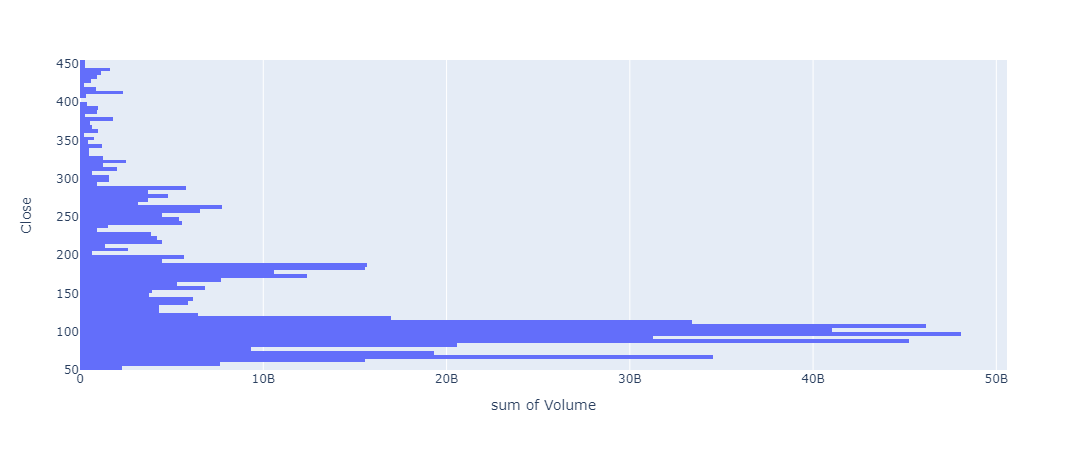

In [125]:
px.histogram(df_stock_wk, x='Volume', y='Close', nbins=150, orientation='h').show()

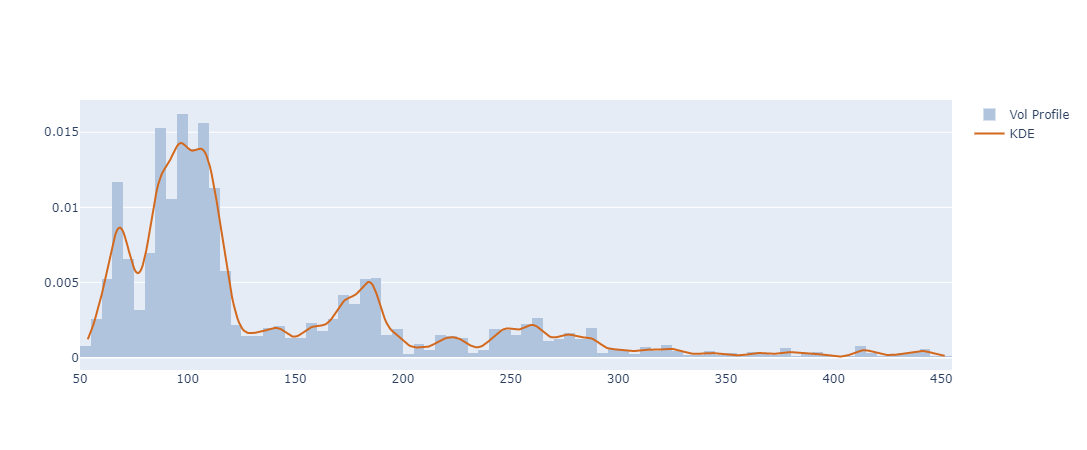

In [126]:
kde_factor = 0.05
num_samples = 500
close = df_stock_wk['Close']
volume = df_stock_wk['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

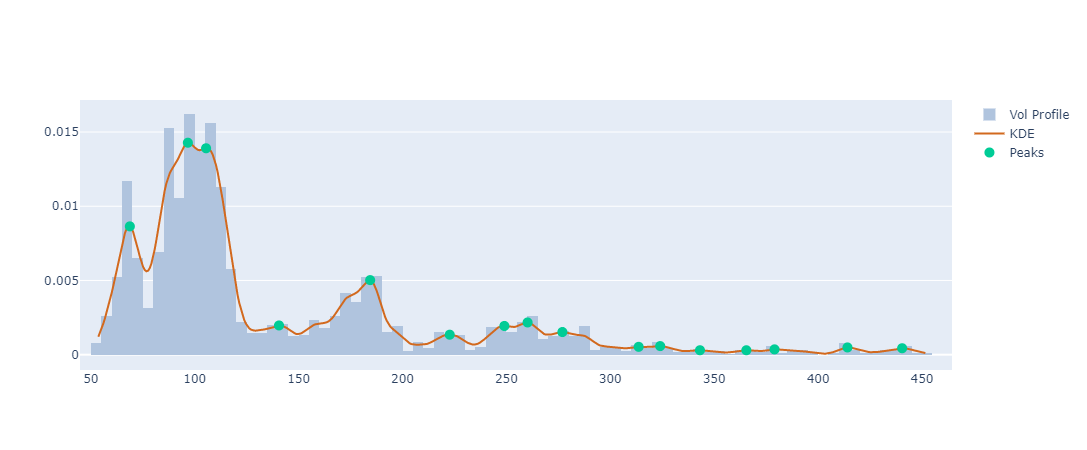

In [128]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [129]:
stock_df_mo = stock.history(period="10y", interval='1mo')
stock_df_mo.index.duplicated().sum()
df_stock_mo = stock_df_mo.loc[~stock_df_mo.index.duplicated(keep='first')]
df_stock_mo.dropna(inplace=True)
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2011-10-01   92.621994  106.561815   88.455694  103.334167  5.721102e+09   
2011-11-01  100.477027  105.409076   95.676722  102.914230  5.013586e+09   
2011-12-01  102.798969  104.783318   98.830279  103.334167  3.848636e+09   
2012-01-01  105.862162  110.535469  104.760120  108.811989  2.883821e+09   
2012-02-01  109.615709  114.504466  109.483142  113.535004  2.894582e+09   
2012-03-01  113.775324  117.520608  111.330951  116.675430  3.057516e+09   
2012-04-01  117.045250  118.351861  112.983948  116.404427  3.035644e+09   
2012-05-01  116.337837  117.894121  107.815780  109.413666  4.004156e+09   
2012-06-01  107.699274  113.408392  105.810101  113.266914  3.644886e+09   
2012-07-01  114.171693  116.564213  110.925906  115.200653  2.864743e+09   
2012-08-01  116.028839  119.701273  113.418822  118.086746  2.413591e+09   
2012-09-01  117.986354  123.900736  117.225108  120.437439  2.391234e+09   
2012-10-01  121.542887  123.763155  118.069508  118.876884  2.719916e+09   
2012-11-01  119.129208  120.870107  113.284184  119.549713  3.032769e+09   
2012-12-01  120.096342  122.434351  117.354639  119.768349  2.889876e+09   
2013-01-01  122.904651  127.842521  122.582796  126.792267  2.587140e+09   
2013-02-01  127.596901  129.824452  125.970709  128.410004  2.581459e+09   
2013-03-01  127.969553  132.848141  127.393616  132.695679  2.330972e+09   
2013-04-01  133.217781  135.880610  130.631530  135.846573  2.907035e+09   
2013-05-01  135.548823  143.835061  134.502414  139.053879  2.781596e+09   
2013-06-01  139.377202  141.214810  132.486180  136.476166  3.533322e+09   
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382983  146.221118  139.447585  139.960724  2.283132e+09   
2013-09-01  141.311982  148.470384  140.003460  143.689560  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273869  156.198301  150.191000  155.553741  1.930953e+09   
2013-12-01  155.631114  158.725006  152.391136  158.725006  2.232776e+09   
2014-01-01  158.973207  159.802729  152.838256  153.961548  2.530651e+09   
2014-02-01  153.780095  161.712331  150.099124  160.969223  2.394185e+09   
2014-03-01  159.552173  163.328207  158.774508  161.591400  2.554084e+09   
2014-04-01  162.833983  164.639201  157.357583  163.432831  2.345902e+09   
2014-05-01  163.354687  167.329635  161.436639  167.225479  1.781094e+09   
2014-06-01  167.459856  170.627672  166.609325  169.863922  1.675047e+09   
2014-07-01  171.096433  173.590500  168.279712  168.384354  1.893710e+09   
2014-08-01  167.922178  175.125330  166.169360  175.029404  1.829885e+09   
2014-09-01  175.256123  176.067124  170.965633  171.811523  2.106463e+09   
2014-10-01  172.334287  176.820069  159.385123  176.679886  3.943068e+09   
2014-11-01  176.907633  182.120588  175.278036  181.533585  1.571092e+09   
2014-12-01  180.832724  186.588889  173.350601  180.079254  3.045171e+09   
2015-01-01  181.813165  182.253647  174.915223  175.708084  3.183506e+09   
2015-02-01  176.236675  186.975618  174.307364  185.583694  1.901638e+09   
2015-03-01  185.689372  186.817004  179.822155  181.857178  2.749923e+09   
2015-04-01  182.633592  188.022602  180.969984  184.465332  2.036685e+09   
2015-05-01  185.297130  189.172977  182.961006  186.836853  1.892520e+09   
2015-06-01  187.544741  188.783589  181.651334  182.155731  2.535243e+09   
2015-07-01  184.713457  189.559593  181.494558  187.176544  2.452758e+09   
2015-08-01  187.141017  187.896829  162.190056  175.768143  3.734927e+09   
2015-09-01  171.722253  180.409739  166.218104  170.397354  3.279513e+09   
2015-10-01  171.685444  187.202205  169.039723  185.852524  2.536184e+09   
2015-11-01  186.201166  189.186530  180.713081  186.531876  1.924513e+09   
2015-12-01  187.202201  188.596562  178.612565  182.223602  2.9248

In [130]:
# calculate Bollinger Bands on monthly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_mo = df_stock_mo['Close'].ewm(span=length).mean()
df_stock_mo['Moving average monthly'] = m_avg_mo
# standard deviation
m_std_mo = df_stock_mo['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock_mo['upper_BB'] = m_avg_mo + mult * m_std_mo
# lower Bollinger Bands 
df_stock_mo['lower_BB'] = m_avg_mo - mult * m_std_mo
df_stock_mo.head()
df_stock_mo.dropna(inplace=True)

In [131]:
df_stock_mo.isnull().sum()

Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Dividends                 0
Stock Splits              0
Moving average monthly    0
upper_BB                  0
lower_BB                  0
dtype: int64

In [132]:
#Stacked Moving averages monthly 
m_avg_08_mo = df_stock_mo['Close'].ewm(span=8).mean()
m_avg_21_mo = df_stock_mo['Close'].ewm(span=21).mean()
m_avg_34_mo = df_stock_mo['Close'].ewm(span=34).mean()
m_avg_55_mo = df_stock_mo['Close'].ewm(span=55).mean()
m_avg_89_mo = df_stock_mo['Close'].ewm(span=89).mean()

df_stock_mo['m_avg_08'] = m_avg_08_mo
df_stock_mo['m_avg_21'] = m_avg_21_mo
df_stock_mo['m_avg_34'] = m_avg_34_mo
df_stock_mo['m_avg_55'] = m_avg_55_mo
df_stock_mo['m_avg_89'] = m_avg_89_mo

In [133]:
# calculate Keltner Channel monthly
# first we need to calculate True Range
df_stock_mo['tr0'] = abs(df_stock_mo["High"] - df_stock_mo["Low"])
df_stock_mo['tr1'] = abs(df_stock_mo["High"] - df_stock_mo["Close"].shift())
df_stock_mo['tr2'] = abs(df_stock_mo["Low"] - df_stock_mo["Close"].shift())
df_stock_mo['tr'] = df_stock_mo[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_mo = df_stock_mo['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_mo['upper_KC'] = m_avg_mo + range_ma_mo * mult_KC
# lower Keltner Channel
df_stock_mo['lower_KC'] = m_avg_mo - range_ma_mo * mult_KC
df_stock_mo.tail()

Open        High         Low       Close        Volume  \
Date                                                                       
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114774  452.600006  427.490447  433.062622  1.604493e+09   
2021-09-30  436.019989  436.760010  430.000000  431.470001  6.228721e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2021-06-01        0.0             0              351.081706  448.968552   
2021-07-01        0.0             0              359.274904  464.895734   
2021-08-01        0.0             0              367.926684  481.915863   
2021-09-01        0.0             0              374.130144  491.869066   
2021-09-30        0.0             0              379.591113  496.657442   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2021-06-01  253.194859  391.131883  348.660291  323.392036  297.878871   
2021-07-01  253.654074  401.349165  356.701784  329.909426  302.991026   
2021-08-01  253.937504  412.186679  365.194782  336.797659  308.387694   
2021-09-01  256.391222  416.825778  371.364993  342.312989  312.956401   
2021-09-30  262.524785  420.080050  376.829412  347.420313  317.295288   

              m_avg_89        tr0        tr1        tr2         tr  \
Date                                                                 
2021-06-01  276.425333  13.989256   8.683684   5.305572  13.989256   
2021-07-01  280.428824  19.766660  15.087516   4.679144  19.766660   
2021-08-01  284.645317  16.915809  14.513519   2.402290  16.915809   
2021-09-01  288.323580  25.109560   2.482025  22.627534  25.109560   
2021-09-30  291.862152   6.760010   3.697388   3.062622   6.760010   

              upper_KC    lower_KC  
Date                                
2021-06-01  401.083683  301.079728  
2021-07-01  408.325110  310.224698  
2021-08-01  415.593281  320.260087  
2021-09-01  422.028804  326.231484  
2021-09-30  424.364255  334.817971

In [134]:
#ADX Calculations monthly

plus_dm_mo = df_stock_mo["High"].diff()
minus_dm_mo = df_stock_mo["Low"].diff()
plus_dm_mo[plus_dm_mo < 0] = 0
minus_dm_mo[minus_dm_mo > 0] = 0

df_stock_mo['atr'] = df_stock_mo['tr'].ewm(span=14).mean()
df_stock_mo['plus_di'] = 100 * (plus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr'])
df_stock_mo['minus_di'] = abs(100 * (minus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr']))
dx_mo = (abs(df_stock_mo['plus_di'] - df_stock_mo['minus_di']) / abs(df_stock_mo['plus_di'] + df_stock_mo['minus_di'])) * 100
adx_mo = ((dx_mo.shift(1) * (14 - 1)) + dx_mo) / 14
df_stock_mo['adx'] = adx_mo.ewm(alpha = 1/14).mean()
df_stock_mo.dropna(inplace=True)
df_stock_mo.head()

Open        High         Low       Close        Volume  \
Date                                                                       
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382983  146.221118  139.447585  139.960724  2.283132e+09   
2013-09-01  141.311982  148.470384  140.003460  143.689560  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273869  156.198301  150.191000  155.553741  1.930953e+09   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2013-07-01        0.0             0              127.002638  149.197601   
2013-08-01        0.0             0              128.373965  150.178323   
2013-09-01        0.0             0              129.977799  152.347735   
2013-10-01        0.0             0              132.166455  156.546699   
2013-11-01        0.0             0              134.572104  161.457111   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2013-07-01  104.807674  140.409259  140.110709  140.044035  140.003636   
2013-08-01  106.569607  140.252056  140.067695  140.021334  139.992316   
2013-09-01  107.607862  141.319878  140.936276  140.843751  140.786502   
2013-10-01  107.786211  144.104383  143.052829  142.809484  142.661070   
2013-11-01  107.687097  147.177889  145.387153  144.966612  144.709775   

              m_avg_89        tr0       tr1       tr2         tr    upper_KC  \
Date                                                                           
2013-07-01  139.978931   8.244554  8.795614  0.551060   8.795614  144.873836   
2013-08-01  139.974225   6.773533  1.932865  4.840669   6.773533  145.005039   
2013-09-01  140.751059   8.466925  8.509661  0.042736   8.509661  146.701980   
2013-10-01  142.570031  11.155179  8.864865  2.290314  11.155179  150.056661   
2013-11-01  144.552205   6.007301  5.122068  0.885233   6.007301  151.365146   

              lower_KC       atr    plus_di   minus_di        adx  
Date                                                               
2013-07-01  109.131440  8.927527  23.563233  10.874000  95.489102  
2013-08-01  111.742892  8.268559  20.439066   7.533736  65.426301  
2013-09-01  113.253617  8.331462  22.153762   5.395020  58.890152  
2013-10-01  114.276248  8.984820  26.289604   3.848662  59.702124  
2013-11-01  117.779063  8.357394  31.315308   3.314245  63.211955

In [135]:
# check for 'squeeze' monthly
df_stock_mo['squeeze_on'] = (df_stock_mo['lower_BB'] > df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] < df_stock_mo['upper_KC'])
df_stock_mo['squeeze_off'] = (df_stock_mo['lower_BB'] < df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] > df_stock_mo['upper_KC'])
df_stock_mo.head()

Open        High         Low       Close        Volume  \
Date                                                                       
2013-07-01  137.916674  145.271779  137.027226  144.288254  2.330904e+09   
2013-08-01  145.382983  146.221118  139.447585  139.960724  2.283132e+09   
2013-09-01  141.311982  148.470384  140.003460  143.689560  2.226750e+09   
2013-10-01  144.501728  152.554425  141.399245  151.076233  2.901739e+09   
2013-11-01  151.273869  156.198301  150.191000  155.553741  1.930953e+09   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2013-07-01        0.0             0              127.002638  149.197601   
2013-08-01        0.0             0              128.373965  150.178323   
2013-09-01        0.0             0              129.977799  152.347735   
2013-10-01        0.0             0              132.166455  156.546699   
2013-11-01        0.0             0              134.572104  161.457111   

              lower_BB    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                     
2013-07-01  104.807674  140.409259  140.110709  140.044035  140.003636   
2013-08-01  106.569607  140.252056  140.067695  140.021334  139.992316   
2013-09-01  107.607862  141.319878  140.936276  140.843751  140.786502   
2013-10-01  107.786211  144.104383  143.052829  142.809484  142.661070   
2013-11-01  107.687097  147.177889  145.387153  144.966612  144.709775   

              m_avg_89        tr0       tr1       tr2         tr    upper_KC  \
Date                                                                           
2013-07-01  139.978931   8.244554  8.795614  0.551060   8.795614  144.873836   
2013-08-01  139.974225   6.773533  1.932865  4.840669   6.773533  145.005039   
2013-09-01  140.751059   8.466925  8.509661  0.042736   8.509661  146.701980   
2013-10-01  142.570031  11.155179  8.864865  2.290314  11.155179  150.056661   
2013-11-01  144.552205   6.007301  5.122068  0.885233   6.007301  151.365146   

              lower_KC       atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                            
2013-07-01  109.131440  8.927527  23.563233  10.874000  95.489102       False   
2013-08-01  111.742892  8.268559  20.439066   7.533736  65.426301       False   
2013-09-01  113.253617  8.331462  22.153762   5.395020  58.890152       False   
2013-10-01  114.276248  8.984820  26.289604   3.848662  59.702124       False   
2013-11-01  117.779063  8.357394  31.315308   3.314245  63.211955       False   

            squeeze_off  
Date                     
2013-07-01         True  
2013-08-01         True  
2013-09-01         True  
2013-10-01         True  
2013-11-01         True

In [136]:
# Momentum monthly
highest_mo = df_stock_mo['High'].rolling(window = length_KC).max()
lowest_mo = df_stock_mo['Low'].rolling(window = length_KC).min()
m1_mo = (highest_mo + lowest_mo) / 2
df_stock_mo['value'] = (df_stock_mo['Close'] - (m1_mo + m_avg_mo)/2)
fit_y_mo = np.array(range(0,length_KC))
df_stock_mo['value'] = df_stock_mo['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_mo, x, 1)[1], raw=True)

df_stock_mo[['squeeze_on', 'squeeze_off']] = (df_stock_mo[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock_mo["pct_change"] = df_stock_mo['Close'].pct_change()
df_stock_mo.dropna(inplace=True)
"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_mo =  [
    (df_stock_mo['pct_change'] > 0),
    (df_stock_mo['pct_change'] < 0)
]

label = [1, 0]
df_stock_mo['profitable?'] = np.select(conditions_mo, label) 

df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2016-11-01  194.419733  202.536928  190.265281  201.222107  2.073824e+09   
2016-12-01  201.541656  208.490110  200.099006  204.098251  1.821910e+09   
2017-01-01  206.688045  210.977220  205.622653  208.974991  1.482408e+09   
2017-02-01  208.975040  217.957484  208.322948  217.185989  1.365137e+09   
2017-03-01  218.949391  220.722007  212.722298  216.515503  1.921474e+09   
2017-04-01  217.512791  220.953511  214.477935  219.615967  1.549614e+09   
2017-05-01  220.169418  223.305743  217.171468  222.715378  1.492547e+09   
2017-06-01  223.204269  226.008499  221.350158  223.047455  1.572753e+09   
2017-07-01  225.136297  229.882249  222.781850  228.742111  1.055909e+09   
2017-08-01  229.381693  230.725760  224.162991  229.409500  1.557032e+09   
2017-09-01  229.808097  232.959717  227.055071  232.876282  1.286405e+09   
2017-10-01  234.274145  240.236039  234.087825  239.546677  1.320625e+09   
2017-11-01  240.375800  247.837454  238.130774  246.868668  1.365621e+09   
2017-12-01  246.635804  250.212933  242.909625  248.592026  1.715223e+09   
2018-01-01  250.780327  268.373534  250.368350  263.944794  1.985507e+09   
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811781  255.037274  239.404147  248.654312  1.998466e+09   
2018-05-01  248.052648  257.810437  243.521570  254.698853  1.606397e+09   
2018-06-01  256.080670  262.726873  252.395638  255.018402  1.599001e+09   
2018-07-01  254.492198  268.524145  254.237224  265.653534  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689356  277.560899  270.733763  274.520325  1.228103e+09   
2018-10-01  277.081513  278.124926  246.481245  256.706635  3.024346e+09   
2018-11-01  257.626669  266.751733  249.535524  261.468292  2.021061e+09   
2018-12-01  265.860158  265.973980  221.733514  237.062119  3.102780e+09   
2019-01-01  234.687359  258.053059  232.483411  257.537842  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565273  272.087655  259.913474  269.511627  1.678081e+09   
2019-04-01  272.826203  282.169565  272.538697  281.757477  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827842  283.952010  261.700428  280.780060  1.340436e+09   
2019-07-01  285.689344  291.033759  283.426395  286.411560  1.110102e+09   
2019-08-01  286.575299  289.724150  271.283575  281.616089  2.034005e+09   
2019-09-01  279.805730  291.418961  278.553872  285.776031  1.303830e+09   
2019-10-01  288.034064  294.622064  275.535255  293.441833  1.386748e+09   
2019-11-01  294.980110  305.195868  294.805955  304.063995  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531881  323.679887  311.440397  312.772278  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907130  305.101959  212.183127  250.573639  5.926018e+09   
2020-04-01  242.493274  288.355589  238.503545  284.052948  2.819312e+09   
2020-05-01  278.997330  300.050964  266.949911  297.586731  1.910460e+09   
2020-06-01  296.902178  316.254318  290.174398  301.537292  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613248  359.318451  322.694343  357.030670  1.535244e+09   
2020-12-01  360.491928  373.202860  357.001094  368.686493  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.4022

In [137]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_mo = (df_stock_mo['squeeze_off'].iloc[-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_mo = df_stock_mo['value'][-1] > 0

enter_long_mo = long_cond1_mo and long_cond2_mo
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_mo = (df_stock_mo['squeeze_off'][-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_mo = df_stock_mo['value'][-1] < 0
enter_short_mo = short_cond1_mo and short_cond2_mo

In [138]:
ohcl_mo = df_stock_mo[['Open', 'High', 'Close', 'Low']]
ohcl_mo.head()

Open        High       Close         Low
Date                                                      
2016-11-01  194.419733  202.536928  201.222107  190.265281
2016-12-01  201.541656  208.490110  204.098251  200.099006
2017-01-01  206.688045  210.977220  208.974991  205.622653
2017-02-01  208.975040  217.957484  217.185989  208.322948
2017-03-01  218.949391  220.722007  216.515503  212.722298

In [139]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_mo['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_mo['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_mo['value'][ind-1]:
      color='red'
  colors.append(color)

In [140]:
len(colors)

60

In [141]:
df_stock_mo['colors'] = colors

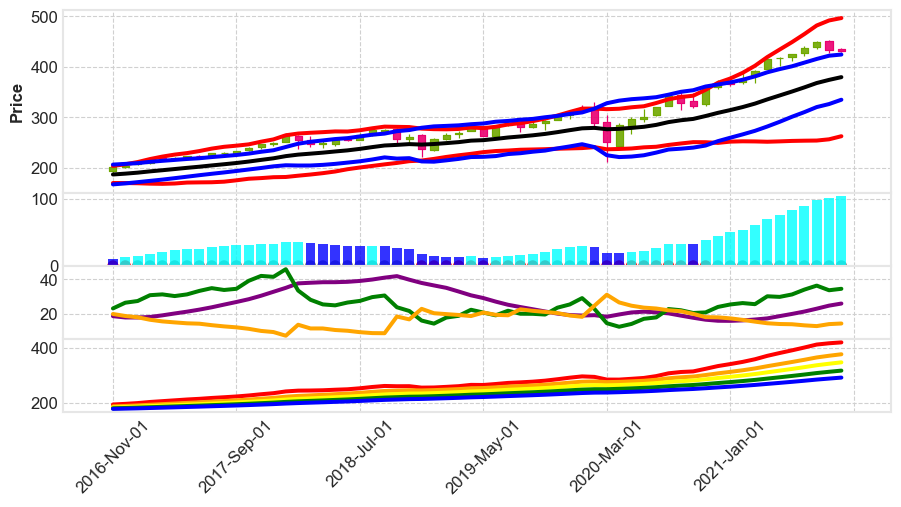

In [143]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
        mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

In [144]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_mo = stochastics( df_stock_mo, 'Low', 'High', 'Close', 14, 3 )
slow_k_mo = stochs_mo['k_slow'].values
fast_k_mo = stochs_mo['k_fast'].values
df_stock_mo["slow_K"] = slow_k_mo
df_stock_mo['fast_K'] = fast_k_mo
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2016-11-01  194.419733  202.536928  190.265281  201.222107  2.073824e+09   
2016-12-01  201.541656  208.490110  200.099006  204.098251  1.821910e+09   
2017-01-01  206.688045  210.977220  205.622653  208.974991  1.482408e+09   
2017-02-01  208.975040  217.957484  208.322948  217.185989  1.365137e+09   
2017-03-01  218.949391  220.722007  212.722298  216.515503  1.921474e+09   
2017-04-01  217.512791  220.953511  214.477935  219.615967  1.549614e+09   
2017-05-01  220.169418  223.305743  217.171468  222.715378  1.492547e+09   
2017-06-01  223.204269  226.008499  221.350158  223.047455  1.572753e+09   
2017-07-01  225.136297  229.882249  222.781850  228.742111  1.055909e+09   
2017-08-01  229.381693  230.725760  224.162991  229.409500  1.557032e+09   
2017-09-01  229.808097  232.959717  227.055071  232.876282  1.286405e+09   
2017-10-01  234.274145  240.236039  234.087825  239.546677  1.320625e+09   
2017-11-01  240.375800  247.837454  238.130774  246.868668  1.365621e+09   
2017-12-01  246.635804  250.212933  242.909625  248.592026  1.715223e+09   
2018-01-01  250.780327  268.373534  250.368350  263.944794  1.985507e+09   
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811781  255.037274  239.404147  248.654312  1.998466e+09   
2018-05-01  248.052648  257.810437  243.521570  254.698853  1.606397e+09   
2018-06-01  256.080670  262.726873  252.395638  255.018402  1.599001e+09   
2018-07-01  254.492198  268.524145  254.237224  265.653534  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689356  277.560899  270.733763  274.520325  1.228103e+09   
2018-10-01  277.081513  278.124926  246.481245  256.706635  3.024346e+09   
2018-11-01  257.626669  266.751733  249.535524  261.468292  2.021061e+09   
2018-12-01  265.860158  265.973980  221.733514  237.062119  3.102780e+09   
2019-01-01  234.687359  258.053059  232.483411  257.537842  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565273  272.087655  259.913474  269.511627  1.678081e+09   
2019-04-01  272.826203  282.169565  272.538697  281.757477  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827842  283.952010  261.700428  280.780060  1.340436e+09   
2019-07-01  285.689344  291.033759  283.426395  286.411560  1.110102e+09   
2019-08-01  286.575299  289.724150  271.283575  281.616089  2.034005e+09   
2019-09-01  279.805730  291.418961  278.553872  285.776031  1.303830e+09   
2019-10-01  288.034064  294.622064  275.535255  293.441833  1.386748e+09   
2019-11-01  294.980110  305.195868  294.805955  304.063995  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531881  323.679887  311.440397  312.772278  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907130  305.101959  212.183127  250.573639  5.926018e+09   
2020-04-01  242.493274  288.355589  238.503545  284.052948  2.819312e+09   
2020-05-01  278.997330  300.050964  266.949911  297.586731  1.910460e+09   
2020-06-01  296.902178  316.254318  290.174398  301.537292  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613248  359.318451  322.694343  357.030670  1.535244e+09   
2020-12-01  360.491928  373.202860  357.001094  368.686493  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.4022

In [145]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_mo['rsi_14'] = get_rsi(df_stock_mo['Close'], 14)
df_stock_mo = df_stock_mo.dropna()
df_stock_mo['Overbought'] = 70
df_stock_mo['Oversold'] = 30
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2018-02-01  263.167613  265.030853  236.810583  254.347595  2.923722e+09   
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811781  255.037274  239.404147  248.654312  1.998466e+09   
2018-05-01  248.052648  257.810437  243.521570  254.698853  1.606397e+09   
2018-06-01  256.080670  262.726873  252.395638  255.018402  1.599001e+09   
2018-07-01  254.492198  268.524145  254.237224  265.653534  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689356  277.560899  270.733763  274.520325  1.228103e+09   
2018-10-01  277.081513  278.124926  246.481245  256.706635  3.024346e+09   
2018-11-01  257.626669  266.751733  249.535524  261.468292  2.021061e+09   
2018-12-01  265.860158  265.973980  221.733514  237.062119  3.102780e+09   
2019-01-01  234.687359  258.053059  232.483411  257.537842  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565273  272.087655  259.913474  269.511627  1.678081e+09   
2019-04-01  272.826203  282.169565  272.538697  281.757477  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827842  283.952010  261.700428  280.780060  1.340436e+09   
2019-07-01  285.689344  291.033759  283.426395  286.411560  1.110102e+09   
2019-08-01  286.575299  289.724150  271.283575  281.616089  2.034005e+09   
2019-09-01  279.805730  291.418961  278.553872  285.776031  1.303830e+09   
2019-10-01  288.034064  294.622064  275.535255  293.441833  1.386748e+09   
2019-11-01  294.980110  305.195868  294.805955  304.063995  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531881  323.679887  311.440397  312.772278  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907130  305.101959  212.183127  250.573639  5.926018e+09   
2020-04-01  242.493274  288.355589  238.503545  284.052948  2.819312e+09   
2020-05-01  278.997330  300.050964  266.949911  297.586731  1.910460e+09   
2020-06-01  296.902178  316.254318  290.174398  301.537292  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613248  359.318451  322.694343  357.030670  1.535244e+09   
2020-12-01  360.491928  373.202860  357.001094  368.686493  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.402265e+09   
2021-02-01  370.099603  390.351506  366.791963  376.675262  1.307806e+09   
2021-03-01  381.854623  394.263238  368.277446  392.490570  2.401716e+09   
2021-04-01  395.832728  418.008906  395.614144  414.610931  1.462107e+09   
2021-05-01  416.727198  420.095367  401.396635  417.333282  1.547236e+09   
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114774  452.600006  427.490447  433.062622  1.604493e+09   
2021-09-30  436.019989  436.760010  430.000000  431.470001  6.228721e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2018-02-01        0.0             0              226.044720  267.804280   
2018-03-01        0.0             0              227.983057  269.354303   
2018-04-01        0.0             0              229.952474  270.583559   
2018-05-01        0.0             0              232.310057  272.02022

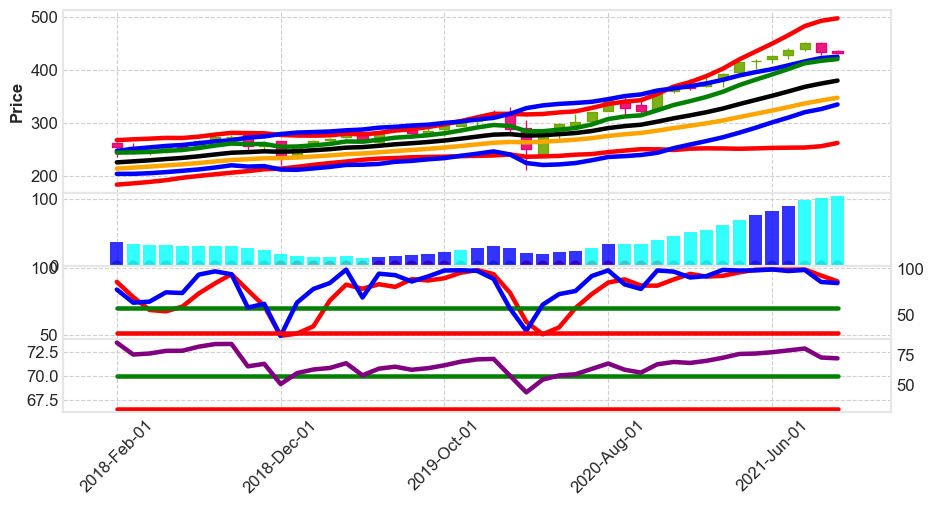

In [147]:

apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
         mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

In [148]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_mo(index):
    if (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index] > df_stock_mo['m_avg_34'][index] > df_stock_mo['m_avg_55'][index] > df_stock_mo['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index] < df_stock_mo['m_avg_34'][index] < df_stock_mo['m_avg_55'][index] < df_stock_mo['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [149]:
df_stock_mo['ADX_trend'] = 20

def ADX_trend_flag_mo(index):
    if (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] > df_stock_mo['minus_di'][index]):
        print('positive trend')
    elif (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] < df_stock_mo['minus_di'][index]):
        print('negative trend')
    elif (df_stock_mo['adx'][index] < df_stock_mo['ADX_trend'][index]):
        print('neutral or sideways trend')

In [150]:
def warning_mo(index):
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this monthly chart')
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_34'][index]):
        print('As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [151]:
def squeeze_momentum_mo(index):
    if (df_stock_mo['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
    if (df_stock_mo['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock_mo['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock_mo['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock_mo['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [153]:
momentum_checker_mo(-1)

Positive momentum


In [154]:
ADX_trend_flag_mo(-1)

positive trend


In [155]:
warning_mo(-1)

Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger


In [156]:
squeeze_momentum_mo(-1)

squeeze is off
stock is in a mark up mode


In [157]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
df_stock_mo['value_threshold'] = abs(df_stock_mo['value'].max()*.15)
df_stock_mo['squeeze_threshold'] = 1.0
df_stock_mo["squeeze_entry"] = np.logical_and(np.greater(df_stock_mo["value"], df_stock_mo['value_threshold']), 
                                           np.equal(df_stock_mo['squeeze_on'], df_stock_mo['squeeze_threshold']))
df_stock_mo['squeeze_entry'] = df_stock_mo['squeeze_entry'].astype(float)
df_stock_mo['Entry/Exit'] = df_stock_mo['squeeze_entry'].diff()
df_stock_mo.dropna(inplace=True)

In [158]:
def implement_bb_strategy_mo(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

In [159]:
buy_price_mo, sell_price_mo, squeeze_signal_mo = implement_bb_strategy_mo(df_stock_mo["Close"], df_stock_mo['squeeze_on'], df_stock_mo['value'], 
                                                              df_stock_mo['upper_KC'], df_stock_mo['value_threshold'], df_stock_mo['colors'], 1.50)

In [160]:
df_stock_mo['buy_price'] =  buy_price_mo
df_stock_mo['sell_price'] = sell_price_mo
df_stock_mo['squeeze_signal'] = squeeze_signal_mo
df_stock_mo

Open        High         Low       Close        Volume  \
Date                                                                       
2018-03-01  254.122876  262.549632  241.407821  246.388977  2.323562e+09   
2018-04-01  246.811781  255.037274  239.404147  248.654312  1.998466e+09   
2018-05-01  248.052648  257.810437  243.521570  254.698853  1.606397e+09   
2018-06-01  256.080670  262.726873  252.395638  255.018402  1.599001e+09   
2018-07-01  254.492198  268.524145  254.237224  265.653534  1.266892e+09   
2018-08-01  265.870751  275.483489  263.604491  274.133179  1.308444e+09   
2018-09-01  273.689356  277.560899  270.733763  274.520325  1.228103e+09   
2018-10-01  277.081513  278.124926  246.481245  256.706635  3.024346e+09   
2018-11-01  257.626669  266.751733  249.535524  261.468292  2.021061e+09   
2018-12-01  265.860158  265.973980  221.733514  237.062119  3.102780e+09   
2019-01-01  234.687359  258.053059  232.483411  257.537842  2.048692e+09   
2019-02-01  257.747712  268.395373  255.534214  265.886108  1.371716e+09   
2019-03-01  267.565273  272.087655  259.913474  269.511627  1.678081e+09   
2019-04-01  272.826203  282.169565  272.538697  281.757477  1.209205e+09   
2019-05-01  282.428313  282.648732  263.760742  263.789490  1.845593e+09   
2019-06-01  263.827842  283.952010  261.700428  280.780060  1.340436e+09   
2019-07-01  285.689344  291.033759  283.426395  286.411560  1.110102e+09   
2019-08-01  286.575299  289.724150  271.283575  281.616089  2.034005e+09   
2019-09-01  279.805730  291.418961  278.553872  285.776031  1.303830e+09   
2019-10-01  288.034064  294.622064  275.535255  293.441833  1.386748e+09   
2019-11-01  294.980110  305.195868  294.805955  304.063995  1.037124e+09   
2019-12-01  304.334830  313.244590  297.118023  311.367828  1.285176e+09   
2020-01-01  314.531881  323.679887  311.440397  312.772278  1.392004e+09   
2020-02-01  314.347225  329.639248  277.589942  288.011475  2.110215e+09   
2020-03-01  289.907130  305.101959  212.183127  250.573639  5.926018e+09   
2020-04-01  242.493274  288.355589  238.503545  284.052948  2.819312e+09   
2020-05-01  278.997330  300.050964  266.949911  297.586731  1.910460e+09   
2020-06-01  296.902178  316.254318  290.174398  301.537292  2.358674e+09   
2020-07-01  304.052643  321.397898  303.561555  320.700531  1.505145e+09   
2020-08-01  322.468516  345.038935  321.889035  343.084412  1.045563e+09   
2020-09-01  343.968353  352.356157  314.100333  328.921417  1.814713e+09   
2020-10-01  332.999200  349.102349  318.118817  322.004089  1.629016e+09   
2020-11-01  325.613248  359.318451  322.694343  357.030670  1.535244e+09   
2020-12-01  360.491928  373.202860  357.001094  368.686493  1.344542e+09   
2021-01-01  371.674214  382.112117  361.285844  366.484985  1.402265e+09   
2021-02-01  370.099603  390.351506  366.791963  376.675262  1.307806e+09   
2021-03-01  381.854623  394.263238  368.277446  392.490570  2.401716e+09   
2021-04-01  395.832728  418.008906  395.614144  414.610931  1.462107e+09   
2021-05-01  416.727198  420.095367  401.396635  417.333282  1.547236e+09   
2021-06-01  419.846992  426.016967  412.027711  425.301605  1.282152e+09   
2021-07-01  427.500420  440.389121  420.622461  437.109650  1.422044e+09   
2021-08-01  438.933810  451.623169  434.707360  450.117981  1.253788e+09   
2021-09-01  451.114774  452.600006  427.490447  433.062622  1.604493e+09   
2021-09-30  436.019989  436.760010  430.000000  431.470001  6.228721e+07   

            Dividends  Stock Splits  Moving average monthly    upper_BB  \
Date                                                                      
2018-03-01        0.0             0              227.983057  269.354303   
2018-04-01        0.0             0              229.952474  270.583559   
2018-05-01        0.0             0              232.310057  272.020223   
2018-06-01        0.0             0              234.473409  271.834923   
2018-07-01        0.0             0              237.443755  274.331683

In [161]:
# Visualize exit position relative to close price
exit = df_stock_mo[df_stock_mo['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_mo[df_stock_mo['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_mo[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [162]:
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_mo)):
    if df_stock_mo['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_mo['Close'])):
    if df_stock_mo['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_mo['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_mo['Close']
squeeze_signal_mo = pd.DataFrame(squeeze_signal_mo).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_mo.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_mo.index)

frames = [close_price, squeeze_signal_mo, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0  2018-03-01  246.388977             0.0               0.0
1  2018-04-01  248.654312             0.0               0.0
2  2018-05-01  254.698853             0.0               0.0
3  2018-06-01  255.018402             0.0               0.0
4  2018-07-01  265.653534             0.0               0.0
5  2018-08-01  274.133179             0.0               0.0
6  2018-09-01  274.520325             0.0               0.0
7  2018-10-01  256.706635             0.0               0.0
8  2018-11-01  261.468292             0.0               0.0
9  2018-12-01  237.062119             0.0               0.0
10 2019-01-01  257.537842             0.0               0.0
11 2019-02-01  265.886108             0.0               0.0
12 2019-03-01  269.511627             0.0               0.0
13 2019-04-01  281.757477             1.0               1.0
14 2019-05-01  263.789490             0.0               1.0
15 2019-06-01  280.780060             0.0               1.0
16 2019-07-01  286.411560             0.0               1.0
17 2019-08-01  281.616089             0.0               1.0
18 2019-09-01  285.776031             0.0               1.0
19 2019-10-01  293.441833             0.0               1.0
20 2019-11-01  304.063995             0.0               1.0
21 2019-12-01  311.367828             0.0               1.0
22 2020-01-01  312.772278             0.0               1.0
23 2020-02-01  288.011475             0.0               1.0
24 2020-03-01  250.573639             0.0               1.0
25 2020-04-01  284.052948             0.0               1.0
26 2020-05-01  297.586731             0.0               1.0
27 2020-06-01  301.537292             0.0               1.0
28 2020-07-01  320.700531             0.0               1.0
29 2020-08-01  343.084412             0.0               1.0
30 2020-09-01  328.921417             0.0               1.0
31 2020-10-01  322.004089             0.0               1.0
32 2020-11-01  357.030670             0.0               1.0
33 2020-12-01  368.686493             0.0               1.0
34 2021-01-01  366.484985             0.0               1.0
35 2021-02-01  376.675262             0.0               1.0
36 2021-03-01  392.490570             0.0               1.0
37 2021-04-01  414.610931             0.0               1.0
38 2021-05-01  417.333282             0.0               1.0
39 2021-06-01  425.301605            -1.0               0.0
40 2021-07-01  437.109650             0.0               0.0
41 2021-08-01  450.117981             0.0               0.0
42 2021-09-01  433.062622             0.0               0.0
43 2021-09-30  431.470001             0.0               0.0

In [163]:
stock_ret = pd.DataFrame(np.diff(df_stock_mo['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_mo['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_mo['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in spy is 49101.1
Profit percentage of the Squeeze strategy : 49%
49101.099700927734


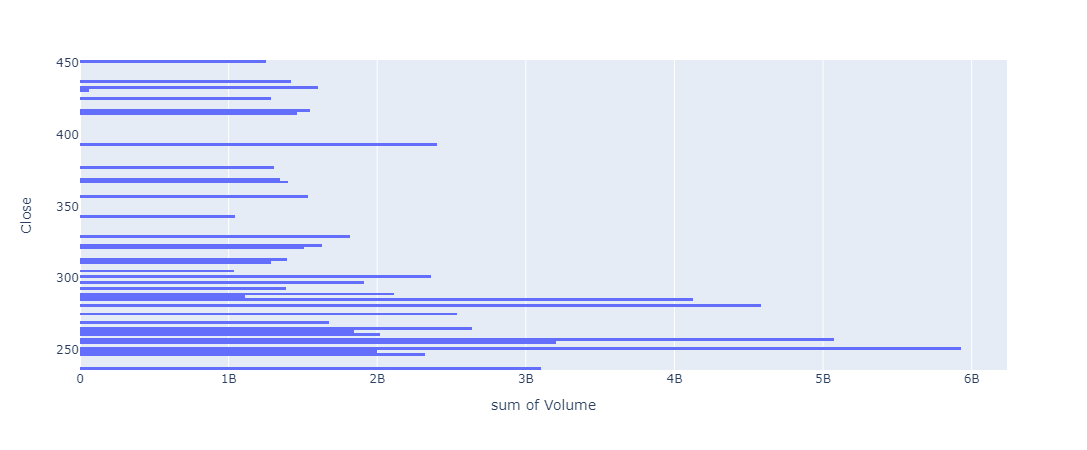

In [164]:
px.histogram(df_stock_mo, x='Volume', y='Close', nbins=150, orientation='h').show()

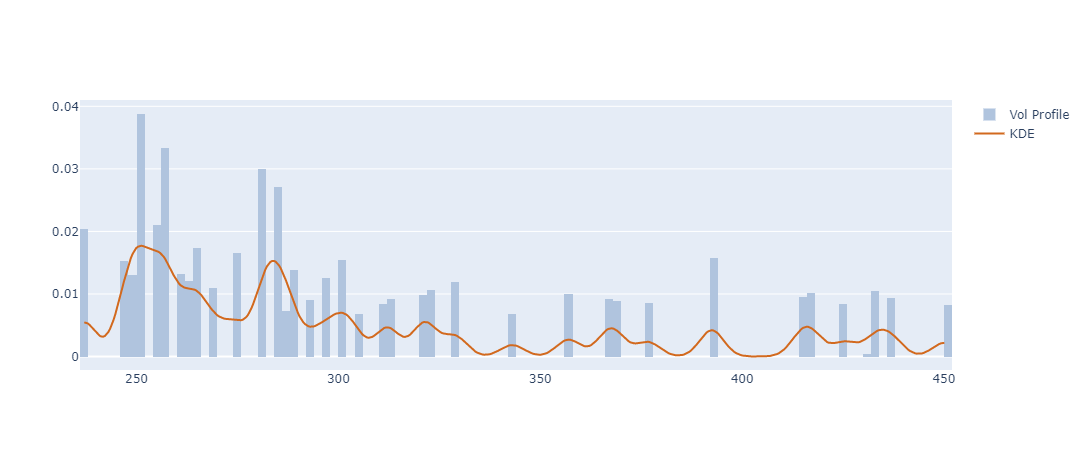

In [165]:
kde_factor = 0.05
num_samples = 500
close = df_stock_mo['Close']
volume = df_stock_mo['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

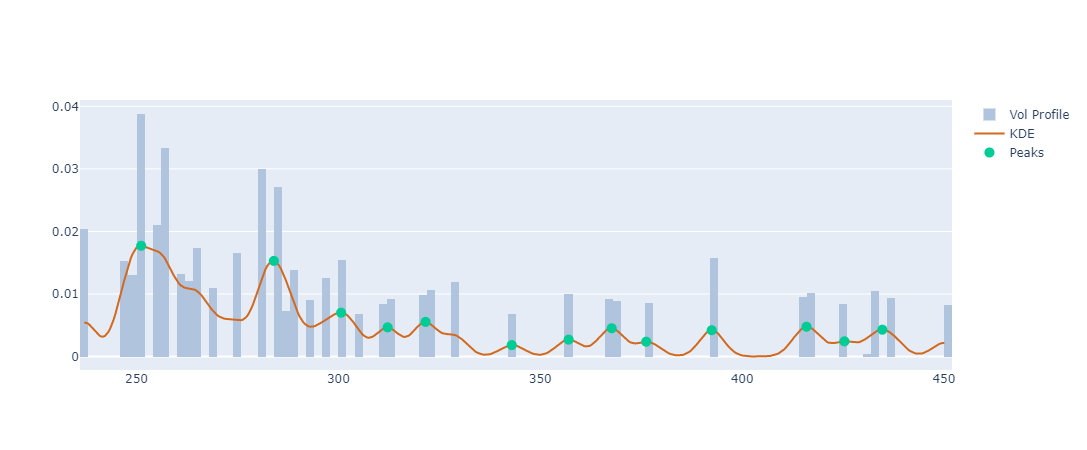

In [166]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [186]:
import panel as pn
from panel.interact import interact
import mplfinance as mpf
%matplotlib widget

pn.extension()

def daily_figure():
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock['Moving average'], color = 'black'),
            mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
            mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
            mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    
    return pn.pane.Matplotlib(fig, tight=True)

def daily_figure_2():
    apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock['Moving average'], color = 'black'),
             mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure(): 
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
            mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure_2():
    apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
             mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure(): 
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
            mpf.make_addplot(df_stock_mo['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_mo['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure_2():
    apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
             mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)
    

In [201]:
# Create a Title for the Dashboard
title = "Stock Trading Dashboard"
momentum_warning_mo = print(momentum_checker_mo(-1))
welcome_tab = pn.Row(pn.Column(title, momentum_warning_mo, ADX_trend_flag_mo(-1), warning_mo(-1), squeeze_momentum_mo(-1)), 
                     pn.Column(momentum_checker_wk(-1), ADX_trend_flag_wk(-1), warning_wk(-1), squeeze_momentum_wk(-1)),
                     pn.Column(momentum_checker(-1), ADX_trend_flag(-1), warning(-1), squeeze_momentum(-1)))

monthly_analysis_tab = pn.Row(monthly_figure(), monthly_figure_2())

# Create a tab layout for the dashboard
weekly_analysis_tab = pn.Row(weekly_figure(), weekly_figure_2())

daily_analysis_tab = pn.Row(daily_figure(), daily_figure_2())



# Create the dashboard
SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Monthly Market Analysis", monthly_analysis_tab),
("Weekly Market Analysis", weekly_analysis_tab), 
("Daily Market Analysis", daily_analysis_tab))

Positive momentum
None
positive trend
Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger
squeeze is off
stock is in a mark up mode
Positive momentum
neutral or sideways trend
Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger
squeeze is off
stock is in a distribution mode
neutral
negative trend
Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.
8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema
squeeze is off
stock is in a mark down mode


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] Str(None)
            [2] Str(None)
            [3] Str(None)
            [4] Str(None)
        [1] Column
            [0] Str(None)
            [1] Str(None)
            [2] Str(None)
            [3] Str(None)
        [2] Column
            [0] Str(None)
            [1] Str(None)
            [2] Str(None)
            [3] Str(None)
    [1] Row
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [2] Row
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [3] Row
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
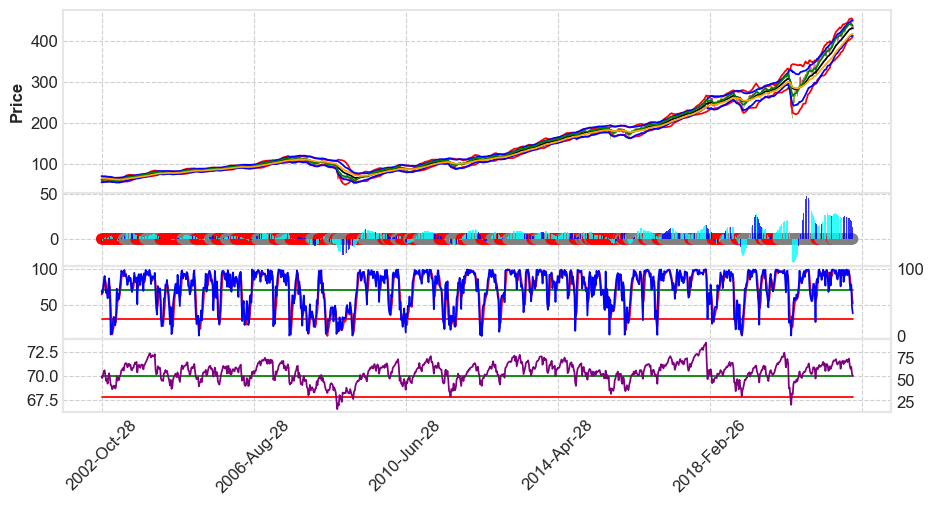
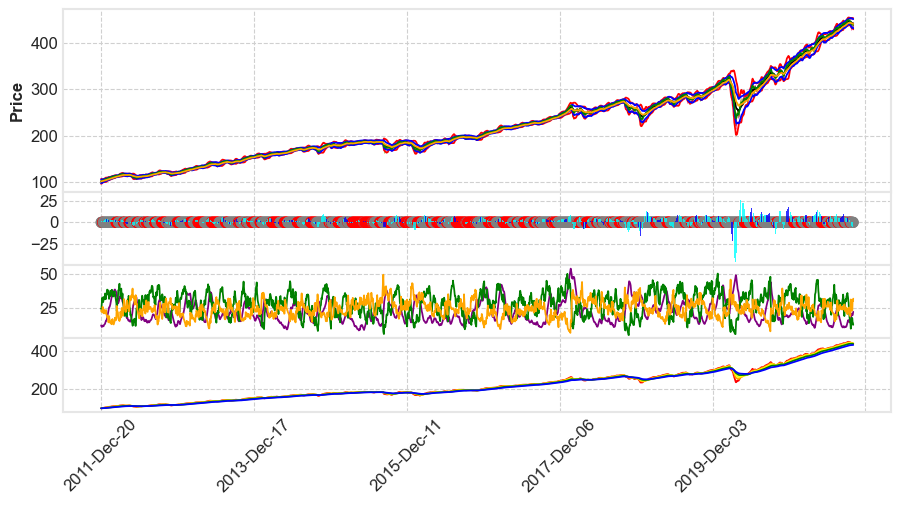
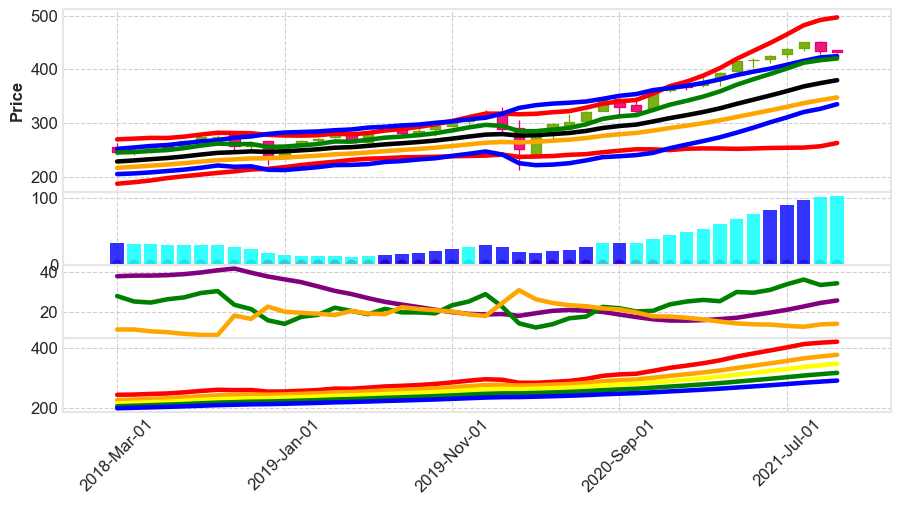
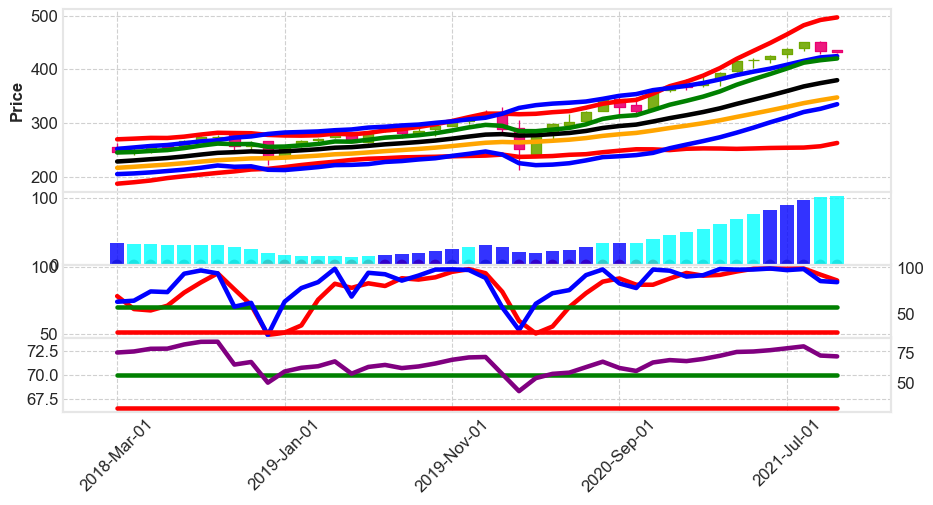
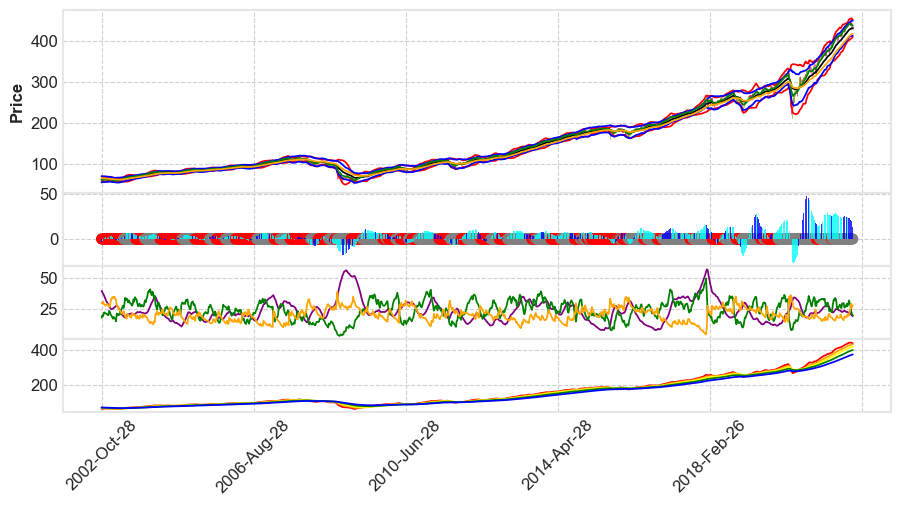
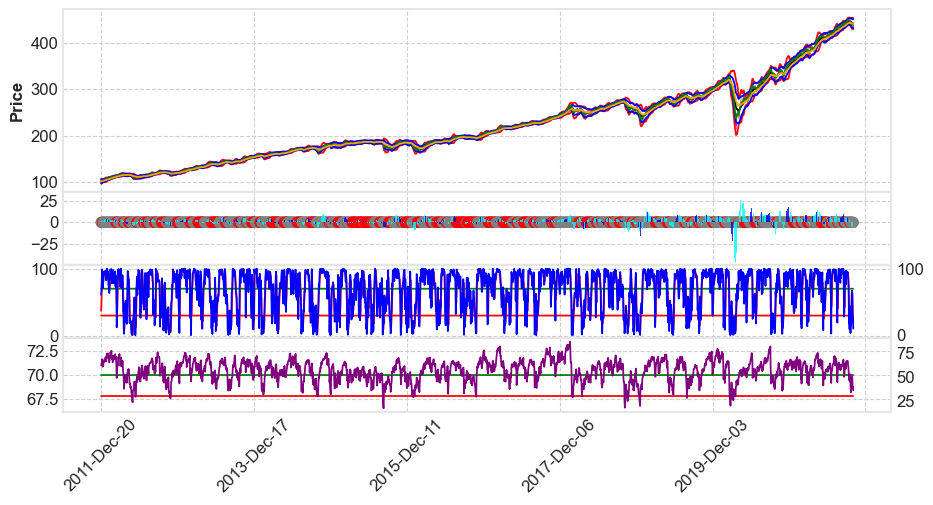

In [202]:
SF_dashboard

In [ ]:
kde_factor = 0.05
num_samples = 500
close = df_stock_wk['Close']
volume = df_stock_wk['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

In [ ]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [ ]:
 # Create our features
X = df_stock.copy()
X.drop(columns=['profitable?',"squeeze_off","tr0","tr1","tr2","tr","Dividends","Stock Splits",'plus_di','minus_di'], axis=1, inplace=True)

# Create our target
y = df_stock[['profitable?']]

y.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, stratify=y)
X_train.shape

In [ ]:
y_train

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [ ]:
# Scale the training and testing data
X_trained_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Resample the training data with the BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1)
rf_model = rf_model.fit(X_trained_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
listed = sorted(zip(rf_model.feature_importances_, X.columns), reverse = True)
listed

In [ ]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
eec_model = eec_model.fit(X_trained_scaled, y_train)
predictions = eec_model.predict(X_test_scaled)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm

In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

In [ ]:
#Add other classifier models

# HW LSTM Model

In [ ]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
df = df_stock[['Volume','squeeze_on', 'adx', 'Close']]
df.head()

In [ ]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 5
dropout_fraction = 0

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

In [ ]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_profit = y_test_scaler.inverse_transform(predicted)
real_profit = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_profit.ravel(),
    "Predicted": predicted_profit.ravel()
}, index = df_stock.index[-len(real_profit): ]) 
stocks.head()

In [ ]:
# Plot the real vs predicted values as a line chart
stocks.plot(figsize = (10,5), title="Actual Vs. Predicted TDOC Closing Prices")

Linear Regression Model

In [ ]:
df_stock['Lagged_Close'] = df_stock['Close'].shift()
df_stock = df_stock.dropna()
df_stock.head()

In [ ]:
# to_period("w") splits the series into weekly increments
df_stock.index.to_period("w")

In [ ]:
# construct a list of all Pandas weekly periods that are in the dataset:
weeks = df_stock.index.to_period("w").unique()
weeks

In [ ]:
# Training Window (26 weeks)
training_window = 26

In [ ]:
# Beginning of training window
start_of_training_period = weeks[0].start_time.strftime(format="%Y-%m-%d")
start_of_training_period

In [ ]:
# End of training window
end_of_training_period = weeks[training_window + 0].end_time.strftime(format="%Y-%m-%d")
end_of_training_period

In [ ]:
# The week of the first test window
test_week = weeks[training_window + 0 + 1]
test_week

In [ ]:
# The first day of the test week
start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
start_of_test_week

In [ ]:
# The last day of the test week
end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
end_of_test_week

In [ ]:
# Training data with just one window
train = df_stock[start_of_training_period:end_of_training_period]
train

In [ ]:
# Testing data with just one window
test = df_stock[start_of_test_week:end_of_test_week]
test

In [ ]:
# Set the training window as 26 weeks
# Total timeframe is 287 weeks
training_window = 26
timeframe = len(weeks) - training_window - 1
timeframe

In [ ]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions

In [ ]:
# Construct a separate empty DataFrame for actual data
all_actuals = pd.DataFrame(columns=["Actual Prices"])
all_actuals

In [ ]:
from sklearn.linear_model import LinearRegression
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window+i+1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df_stock[start_of_training_period:end_of_training_period]
    test = df_stock[start_of_test_week:end_of_test_week]
    
    # Create new DataFrames:
    X_train = train["Lagged_Close"].to_frame()
    y_train = train["Close"]
    X_test = test["Lagged_Close"].to_frame()
    y_test = test["Close"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Create a temporary DataFrame to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Prices"]  
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)

In [ ]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

In [ ]:
# Plot the first 20 predictions vs the true values
Results[:20].plot()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(
    Results["Actual Prices"],
    Results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

# Multifeature LSTM Model

In [ ]:
#multi feature LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
values = df_stock.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,10,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 252
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
#model.add(Dropout(0.3))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
number_units = 50
dropout_fraction = 0.2
# design network
model = Sequential()
model.add(LSTM(units=number_units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# plot history
fig = pyplot.figure()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#self.synaptic_weights = self.synaptic_weights + adjustment
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(764,16))
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape(764,16))
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [166]:
screened_list = []
stock_list = ['AAPL','TSLA','MSFT','AMZN']

for stock_code in stock_list:
    df = yf.download(stock_code, start='2020-01-01', threads= False)
    if enter_long | enter_short:
        screened_list.append(stock_code)
    
if screened_list:
  print(screened_list)
else:
  print('No stock fits the indicator entry requirement')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['AAPL', 'TSLA', 'MSFT', 'AMZN']


In [167]:
help(mpf.plot)

Help on function plot in module mplfinance.plotting:

plot(data, **kwargs)
    Given a Pandas DataFrame containing columns Open,High,Low,Close and optionally Volume
    with a DatetimeIndex, plot the data.
    Available plots include ohlc bars, candlestick, and line plots.
    Also provide visually analysis in the form of common technical studies, such as:
    moving averages, renko, etc.
    Also provide ability to plot trading signals, and/or addtional user-defined data.



In [189]:
tickers = ['NFLX', 'AAPL', 'FB', 'GOOG', 'AMZN', 'PYPL', 'TSLA', 'SQ']

ticker_dict_1mo = {}
ticker_dict_1wk = {}
ticker_dict_1d = {}
for stock in tickers:
    ticker_dict_1mo[stock] = yf.Ticker(stock).history(period="10y", interval='1mo')
    ticker_dict_1mo[stock]["ticker"] = stock
    ticker_dict_1wk[stock] = yf.Ticker(stock).history(period="10y", interval='1wk')
    ticker_dict_1wk[stock]['ticker'] = stock
    ticker_dict_1d[stock] = yf.Ticker(stock).history(period="10y", interval='1d')
    ticker_dict_1d[stock]['ticker'] = stock
    
ticker_dict_1mo['AAPL']

daily_data = pd.concat(ticker_dict_1d.values())
weekly_data = pd.concat(ticker_dict_1wk.values())
monthly_data = pd.concat(ticker_dict_1mo.values())
daily_data

Open        High         Low       Close    Volume  \
Date                                                                   
2011-09-30   15.602857   16.535713   15.375714   16.181429  76881700   
2011-10-03   16.448570   17.134287   16.088572   16.178572  59146500   
2011-10-04   16.382856   16.714287   15.714286   16.414286  50512000   
2011-10-05   16.512857   17.122856   16.000000   17.108570  52418800   
2011-10-06   17.100000   17.750000   16.925714   17.605715  40497100   
...                ...         ...         ...         ...       ...   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   
2021-09-30  236.690002  243.199997  236.279999  242.320007   4337408   

            Dividends  Stock Splits ticker  
Date                                        
2011-09-30        0.0           0.0   NFLX  
2011-10-03        0.0           0.0   NFLX  
2011-10-04        0.0           0.0   NFLX  
2011-10-05        0.0           0.0   NFLX  
2011-10-06        0.0           0.0   NFLX  
...               ...           ...    ...  
2021-09-24        0.0           0.0     SQ  
2021-09-27        0.0           0.0     SQ  
2021-09-28        0.0           0.0     SQ  
2021-09-29        0.0           0.0     SQ  
2021-09-30        0.0           0.0     SQ  

[17992 rows x 8 columns]

In [190]:
# calculate Bollinger Bands
m_avg_mo = {}
m_avg_wk = {}
m_avg_d = {}
m_std_mo = {}
m_std_wk = {}
m_std_d = {}

for stock in tickers:
    # moving average
    m_avg_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).mean()
    m_avg_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).mean()
    m_avg_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).mean()
    # standard deviation
    m_std_mo[stock] = ticker_dict_1mo[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_wk[stock] = ticker_dict_1wk[stock]['Close'].rolling(window=length).std(ddof=0)
    m_std_d[stock] = ticker_dict_1d[stock]['Close'].rolling(window=length).std(ddof=0)
    # upper Bollinger Bands
    ticker_dict_1mo[stock]['upper_BB'] = m_avg_mo[stock] + mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['upper_BB'] = m_avg_wk[stock] + mult * m_std_wk[stock]
    ticker_dict_1d[stock]['upper_BB'] = m_avg_d[stock] + mult * m_std_d[stock]
# lower Bollinger Bands 
    ticker_dict_1mo[stock]['lower_BB'] = m_avg_mo[stock] - mult * m_std_mo[stock]
    ticker_dict_1wk[stock]['lower_BB'] = m_avg_wk[stock] - mult * m_std_wk[stock]
    ticker_dict_1d[stock]['lower_BB'] = m_avg_d[stock] - mult * m_std_d[stock]
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   
2021-09-30  236.690002  243.199997  236.279999  242.320007   4337408   

            Dividends  Stock Splits ticker    upper_BB    lower_BB  
Date                                                                
2015-11-19          0             0     SQ         NaN         NaN  
2015-11-20          0             0     SQ         NaN         NaN  
2015-11-23          0             0     SQ         NaN         NaN  
2015-11-24          0             0     SQ         NaN         NaN  
2015-11-25          0             0     SQ         NaN         NaN  
...               ...           ...    ...         ...         ...  
2021-09-24          0             0     SQ  275.942124  241.772876  
2021-09-27          0             0     SQ  274.923366  241.801631  
2021-09-28          0             0     SQ  273.575603  240.227392  
2021-09-29          0             0     SQ  273.462043  237.137951  
2021-09-30          0             0     SQ  271.983814  236.023180  

[1476 rows x 10 columns]

In [191]:
# calculate Keltner Channel
range_ma_mo = {}
range_ma_wk = {}
range_ma_d = {}

for stock in tickers:
    # first we need to calculate True Range (monthly)
    ticker_dict_1mo[stock]['tr0'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Low"])
    ticker_dict_1mo[stock]['tr1'] = abs(ticker_dict_1mo[stock]["High"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr2'] = abs(ticker_dict_1mo[stock]["Low"] - ticker_dict_1mo[stock]["Close"].shift())
    ticker_dict_1mo[stock]['tr'] = ticker_dict_1mo[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (weekly)
    ticker_dict_1wk[stock]['tr0'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Low"])
    ticker_dict_1wk[stock]['tr1'] = abs(ticker_dict_1wk[stock]["High"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr2'] = abs(ticker_dict_1wk[stock]["Low"] - ticker_dict_1wk[stock]["Close"].shift())
    ticker_dict_1wk[stock]['tr'] = ticker_dict_1wk[stock][['tr0', 'tr1', 'tr2']].max(axis=1)
    
    # first we need to calculate True Range (daily)
    ticker_dict_1d[stock]['tr0'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Low"])
    ticker_dict_1d[stock]['tr1'] = abs(ticker_dict_1d[stock]["High"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr2'] = abs(ticker_dict_1d[stock]["Low"] - ticker_dict_1d[stock]["Close"].shift())
    ticker_dict_1d[stock]['tr'] = ticker_dict_1d[stock][['tr0', 'tr1', 'tr2']].max(axis=1)

    # moving average of the TR
    range_ma_mo[stock] = ticker_dict_1mo[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_wk[stock] = ticker_dict_1wk[stock]['tr'].rolling(window=length_KC).mean()
    range_ma_d[stock] = ticker_dict_1d[stock]['tr'].rolling(window=length_KC).mean()
    
    # upper Keltner Channel
    ticker_dict_1mo[stock]['upper_KC'] = m_avg_mo[stock] + range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['upper_KC'] = m_avg_wk[stock] + range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['upper_KC'] = m_avg_d[stock] + range_ma_d[stock] * mult_KC
    
    # lower Keltner Channel
    ticker_dict_1mo[stock]['lower_KC'] = m_avg_mo[stock] - range_ma_mo[stock] * mult_KC
    ticker_dict_1wk[stock]['lower_KC'] = m_avg_wk[stock] - range_ma_wk[stock] * mult_KC
    ticker_dict_1d[stock]['lower_KC'] = m_avg_d[stock] - range_ma_d[stock] * mult_KC

ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   
2021-09-30  236.690002  243.199997  236.279999  242.320007   4337408   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   
2021-09-30          0             0     SQ  271.983814  236.023180   6.919998   

                 tr1        tr2         tr    upper_KC    lower_KC  
Date                                                                
2015-11-19       NaN        NaN   5.780000         NaN         NaN  
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN  
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN  
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN  
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN  
...              ...        ...        ...         ...         ...  
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215  
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833  
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025  
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094  
2021-09-30  7.160004   0.240005   7.160004  270.680352  237.326642  

[1476 rows x 16 columns]

In [192]:
# check for 'squeeze'
for stock in tickers:
    #monthly
    ticker_dict_1mo[stock]['squeeze_on'] = (ticker_dict_1mo[stock]['lower_BB'] > ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] < ticker_dict_1mo[stock]['upper_KC'])
    ticker_dict_1mo[stock]['squeeze_off'] = (ticker_dict_1mo[stock]['lower_BB'] < ticker_dict_1mo[stock]['lower_KC']) | (ticker_dict_1mo[stock]['upper_BB'] > ticker_dict_1mo[stock]['upper_KC'])
    
    #weekly
    ticker_dict_1wk[stock]['squeeze_on'] = (ticker_dict_1wk[stock]['lower_BB'] > ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] < ticker_dict_1wk[stock]['upper_KC'])
    ticker_dict_1wk[stock]['squeeze_off'] = (ticker_dict_1wk[stock]['lower_BB'] < ticker_dict_1wk[stock]['lower_KC']) | (ticker_dict_1wk[stock]['upper_BB'] > ticker_dict_1wk[stock]['upper_KC'])
    
    #daily
    ticker_dict_1d[stock]['squeeze_on'] = (ticker_dict_1d[stock]['lower_BB'] > ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] < ticker_dict_1d[stock]['upper_KC'])
    ticker_dict_1d[stock]['squeeze_off'] = (ticker_dict_1d[stock]['lower_BB'] < ticker_dict_1d[stock]['lower_KC']) | (ticker_dict_1d[stock]['upper_BB'] > ticker_dict_1d[stock]['upper_KC'])
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   
2021-09-30  236.690002  243.199997  236.279999  242.320007   4337408   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   
2021-09-30          0             0     SQ  271.983814  236.023180   6.919998   

                 tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                 
2015-11-19       NaN        NaN   5.780000         NaN         NaN   
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN   
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN   
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN   
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN   
...              ...        ...        ...         ...         ...   
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215   
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833   
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025   
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094   
2021-09-30  7.160004   0.240005   7.160004  270.680352  237.326642   

            squeeze_on  squeeze_off  
Date                                 
2015-11-19       False        False  
2015-11-20       False        False  
2015-11-23       False        False  
2015-11-24       False        False  
2015-11-25       False        False  
...                ...          ...  
2021-09-24       False         True  
2021-09-27       False         True  
2021-09-28       False         True  
2021-09-29       False         True  
2021-09-30       False         True  

[1476 rows x 18 columns]

In [193]:
# Momentum
highest_mo = {}
highest_wk = {}
highest_d = {}
lowest_mo = {}
lowest_wk = {}
lowest_d = {}
m1_mo = {}
m1_wk = {}
m1_d = {}
fit_y_mo = {}
fit_y_wk = {}
fit_y_d = {}


for stock in tickers:
    #monthly
    highest_mo[stock] = ticker_dict_1mo[stock]['High'].rolling(window = length_KC).max()
    lowest_mo[stock] = ticker_dict_1mo[stock]['Low'].rolling(window = length_KC).min()
    m1_mo[stock] = (highest_mo[stock] + lowest_mo[stock]) / 2
    ticker_dict_1mo[stock]['value'] = (ticker_dict_1mo[stock]['Close'] - (m1_mo[stock] + m_avg_mo[stock])/2)
    fit_y_mo[stock] = np.array(range(0,length_KC))
    ticker_dict_1mo[stock]['value'] = ticker_dict_1mo[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_mo[stock], x, 1)[1], raw=True)
    
    #weekly
    highest_wk[stock] = ticker_dict_1wk[stock]['High'].rolling(window = length_KC).max()
    lowest_wk[stock] = ticker_dict_1wk[stock]['Low'].rolling(window = length_KC).min()
    m1_wk[stock] = (highest_wk[stock] + lowest_wk[stock]) / 2
    ticker_dict_1wk[stock]['value'] = (ticker_dict_1wk[stock]['Close'] - (m1_wk[stock] + m_avg_wk[stock])/2)
    fit_y_wk[stock] = np.array(range(0,length_KC))
    ticker_dict_1wk[stock]['value'] = ticker_dict_1wk[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_wk[stock], x, 1)[1], raw=True)
    
    #daily
    highest_d[stock] = ticker_dict_1d[stock]['High'].rolling(window = length_KC).max()
    lowest_d[stock] = ticker_dict_1d[stock]['Low'].rolling(window = length_KC).min()
    m1_d[stock] = (highest_d[stock] + lowest_d[stock]) / 2
    ticker_dict_1d[stock]['value'] = (ticker_dict_1d[stock]['Close'] - (m1_d[stock] + m_avg_d[stock])/2)
    fit_y_d[stock] = np.array(range(0,length_KC))
    ticker_dict_1d[stock]['value'] = ticker_dict_1d[stock]['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_d[stock], x, 1)[0] * (length_KC-1) +
    np.polyfit(fit_y_d[stock], x, 1)[1], raw=True)
    
ticker_dict_1d[stock]

Open        High         Low       Close    Volume  \
Date                                                                   
2015-11-19   11.200000   14.780000    9.000000   13.070000  47466100   
2015-11-20   13.920000   14.050000   12.500000   12.850000  16550300   
2015-11-23   13.000000   13.150000   12.100000   12.120000   5172200   
2015-11-24   12.000000   12.230000   11.520000   12.020000   4714700   
2015-11-25   12.120000   12.400000   11.850000   11.900000   3583400   
...                ...         ...         ...         ...       ...   
2021-09-24  263.989990  264.970001  257.910004  262.500000   6954900   
2021-09-27  258.100006  259.859985  255.792999  258.109985   4683200   
2021-09-28  252.509995  252.850006  241.619995  242.699997  11052200   
2021-09-29  245.520004  246.240005  235.220001  236.039993   7302500   
2021-09-30  236.690002  243.199997  236.279999  242.320007   4337408   

            Dividends  Stock Splits ticker    upper_BB    lower_BB        tr0  \
Date                                                                            
2015-11-19          0             0     SQ         NaN         NaN   5.780000   
2015-11-20          0             0     SQ         NaN         NaN   1.550000   
2015-11-23          0             0     SQ         NaN         NaN   1.049999   
2015-11-24          0             0     SQ         NaN         NaN   0.709999   
2015-11-25          0             0     SQ         NaN         NaN   0.549999   
...               ...           ...    ...         ...         ...        ...   
2021-09-24          0             0     SQ  275.942124  241.772876   7.059998   
2021-09-27          0             0     SQ  274.923366  241.801631   4.066986   
2021-09-28          0             0     SQ  273.575603  240.227392  11.230011   
2021-09-29          0             0     SQ  273.462043  237.137951  11.020004   
2021-09-30          0             0     SQ  271.983814  236.023180   6.919998   

                 tr1        tr2         tr    upper_KC    lower_KC  \
Date                                                                 
2015-11-19       NaN        NaN   5.780000         NaN         NaN   
2015-11-20  0.980000   0.570000   1.550000         NaN         NaN   
2015-11-23  0.299999   0.750000   1.049999         NaN         NaN   
2015-11-24  0.110000   0.599999   0.709999         NaN         NaN   
2015-11-25  0.379999   0.170000   0.549999         NaN         NaN   
...              ...        ...        ...         ...         ...   
2021-09-24  1.750000   8.809998   8.809998  274.609784  243.105215   
2021-09-27  2.640015   6.707001   6.707001  274.081164  242.643833   
2021-09-28  5.259979  16.489990  16.489990  273.345970  240.457025   
2021-09-29  3.540009   7.479996  11.020004  272.235900  238.364094   
2021-09-30  7.160004   0.240005   7.160004  270.680352  237.326642   

            squeeze_on  squeeze_off     value  
Date                                           
2015-11-19       False        False       NaN  
2015-11-20       False        False       NaN  
2015-11-23       False        False       NaN  
2015-11-24       False        False       NaN  
2015-11-25       False        False       NaN  
...                ...          ...       ...  
2021-09-24       False         True -3.741910  
2021-09-27       False         True -2.934986  
2021-09-28       False         True -4.292634  
2021-09-29       False         True -6.070178  
2021-09-30       False         True -6.772335  

[1476 rows x 19 columns]

In [194]:
long_cond1_mo = {}
long_cond2_mo = {}
enter_long_mo = {}
short_cond1_mo = {}
short_cond2_mo = {}
enter_short_mo = {}
long_cond1_wk = {}
long_cond2_wk = {}
enter_long_wk = {}
short_cond1_wk = {}
short_cond2_wk = {}
enter_short_wk = {}
long_cond1_d = {}
long_cond2_d = {}
enter_long_d = {}
short_cond1_d = {}
short_cond2_d = {}
enter_short_d = {}

for stock in tickers:
    #monthly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] > 0

    enter_long_mo[stock] = long_cond1_mo[stock] and long_cond2_mo[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_mo[stock] = (ticker_dict_1mo[stock]['squeeze_off'][-2] == False) | (ticker_dict_1mo[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_mo[stock] = ticker_dict_1mo[stock]['value'][-1] < 0
    enter_short_mo[stock] = short_cond1_mo[stock] and short_cond2_mo[stock]
    
    #weekly
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] > 0

    enter_long_wk[stock] = long_cond1_wk[stock] and long_cond2_wk[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_wk[stock] = (ticker_dict_1wk[stock]['squeeze_off'][-2] == False) | (ticker_dict_1wk[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_wk[stock] = ticker_dict_1wk[stock]['value'][-1] < 0
    enter_short_wk[stock] = short_cond1_wk[stock] and short_cond2_wk[stock]
    
    #daily
    # entry point for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is positive => the bar is light green
    long_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] > 0

    enter_long_d[stock] = long_cond1_d[stock] and long_cond2_d[stock]
    # entry point for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1_d[stock] = (ticker_dict_1d[stock]['squeeze_off'][-2] == False) | (ticker_dict_1d[stock]['squeeze_off'][-1] == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2_d[stock] = ticker_dict_1d[stock]['value'][-1] < 0
    enter_short_d[stock] = short_cond1_d[stock] and short_cond2_d[stock]

In [195]:
ohcl_mo = {}
ohcl_wk = {}
ohcl_d = {}

for stock in tickers:
    ohcl_mo[stock] = ticker_dict_1mo[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_wk[stock] = ticker_dict_1wk[stock][['Open', 'High', 'Close', 'Low']]
    ohcl_d[stock] = ticker_dict_1d[stock][['Open', 'High', 'Close', 'Low']]
    
ohcl_d[stock]

Open        High       Close         Low
Date                                                      
2015-11-19   11.200000   14.780000   13.070000    9.000000
2015-11-20   13.920000   14.050000   12.850000   12.500000
2015-11-23   13.000000   13.150000   12.120000   12.100000
2015-11-24   12.000000   12.230000   12.020000   11.520000
2015-11-25   12.120000   12.400000   11.900000   11.850000
...                ...         ...         ...         ...
2021-09-24  263.989990  264.970001  262.500000  257.910004
2021-09-27  258.100006  259.859985  258.109985  255.792999
2021-09-28  252.509995  252.850006  242.699997  241.619995
2021-09-29  245.520004  246.240005  236.039993  235.220001
2021-09-30  236.690002  243.199997  242.320007  236.279999

[1476 rows x 4 columns]

In [196]:
ind_mo = {}
val_mo = {}
ind_wk = {}
val_wk = {}
ind_d = {}
val_d = {}

for stock in tickers:
    # add colors for the 'value bar'
    colors_d = []
    for ind_d[stock], val_d[stock] in enumerate(ticker_dict_1d[stock]['value']):
        if val_d[stock] >= 0:
            color_d = 'blue'
        if val_d[stock] > ticker_dict_1d[stock]['value'][ind_d[stock]-1]:
            color_d = 'cyan'
        else:
            color_d = 'yellow'
        if val_d[stock] < ticker_dict_1d[stock]['value'][ind_d[stock]-1]:
            color_d='red'
        colors_d.append(color)
        
    #colors_mo = []
    #for ind_mo[stock], val_mo[stock] in enumerate(ticker_dict_1mo[stock]['value']):
       # if val_mo[stock] >= 0:
            #color_mo = 'green'
        #if val_mo[stock] > ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo = 'lime'
       # else:
            #color_mo = 'maroon'
        #if val_mo[stock] < ticker_dict_1mo[stock]['value'][ind_mo[stock]-1]:
           # color_mo='red'
      #  colors_mo.append(color)
        
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Column
    [0] Column
        [0] Select(name='stock', options=['NFLX', 'AAPL', ...], value='NFLX')
    [1] Row
        [0] Matplotlib(Figure, tight=True)
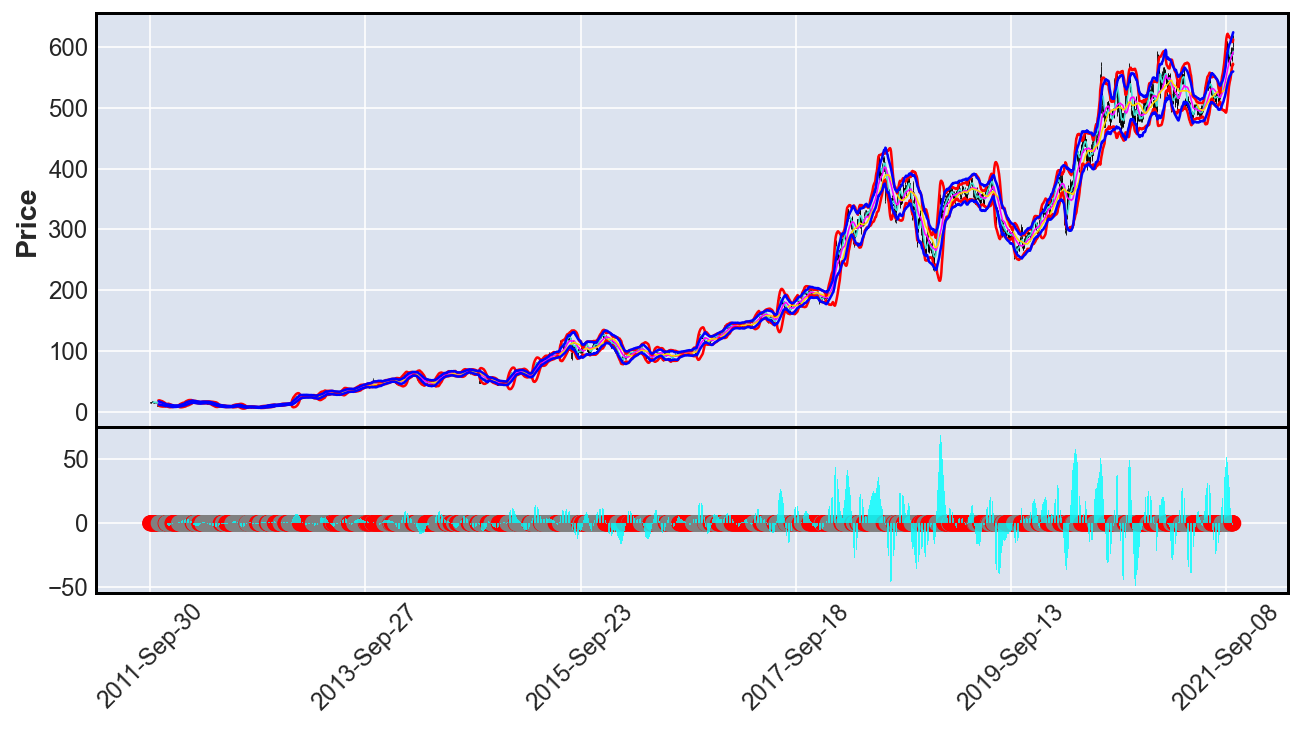

In [197]:
import panel as pn
from panel.interact import interact

pn.extension()

def figure_stock_d(stock):
    apds = [mpf.make_addplot(ticker_dict_1d[stock]['value'], panel=1, type='bar', color=colors_d, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(ticker_dict_1d[stock]), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in ticker_dict_1d[stock]['squeeze_off']], secondary_y=False),
            mpf.make_addplot(ticker_dict_1d[stock][['upper_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1d[stock][['lower_BB']], color = 'red'),
            mpf.make_addplot(ticker_dict_1d[stock][['upper_KC']], color = 'blue'),
            mpf.make_addplot(ticker_dict_1d[stock][['lower_KC']], color = 'blue')]

    # plot ohcl with subplots
    fig, axes = mpf.plot(ohcl_d[stock], 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              mav = (8,21,34),
              type='candle', 
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

ticker = daily_data["ticker"].unique()
interact(figure_stock_d, stock=ticker)